In [ ]:
#### 11.12.2024
#######
##########     ATENTION
#### change code to work with generated dataframe instead of reading the parquet

"""
This scripts run Odds ratio analysis for DoE and 
genetic information on drug clinical success

"""
from functions import (
    discrepancifier,
    build_gwasResolvedColoc,
    temporary_directionOfEffect,
    spreadSheetFormatter,
)

from pyspark.sql.functions import regexp_extract  # type: ignore
from pyspark.sql import SparkSession, Window  # type: ignore
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    ArrayType,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
from datetime import datetime


spark = SparkSession.builder.getOrCreate()
c = datetime.now()
today_date = str(date.today())
print("spark session created at", c)

print("Analysis started on " + today_date + " at ", c)
"""
#coloc = spark.read.parquet(
#    "gs://genetics-portal-dev-data/22.09.1/outputs/v2d_coloc"
#).filter(F.col("right_type") != "gwas")
"""

#### make the dataset from stopped clin trials
### read supplementary table 9
""" ### just showing how i did the dataset
st9 = spark.read.csv("/Users/juanr/Downloads/ST9.csv", sep=",", header=True)
st9.filter(
    (F.col("clinicalStatus").isin(["Terminated", "Withdrawn", "Suspended"]))
    & (F.col("prediction") == "Negative")
).groupBy(
    "targetId", "diseaseId", "clinicalStatus", "prediction"
).count().toPandas().to_csv(
    "targetDiseaseStoppedNegative.csv"
)
"""
### target-diseases terminated&withdrawal in clin trials
terminated = spark.read.csv(
    "gs://ot-team/jroldan/analysis/targetDiseaseStoppedNegative.csv",
    sep=",",
    header=True,
).drop("_c0", "Withdrawn")

path = "gs://open-targets-pre-data-releases/24.12-uo_test-3/output/etl/parquet/"

### new path
path_n='gs://open-targets-data-releases/25.03/output/'
#####
evidences = (
    spark.read.parquet(f"{path_n}evidence").filter(
        F.col("datasourceId").isin(
            [
                #"gwas_credible_sets",
                "gene_burden",
                "eva",
                "eva_somatic",
                "gene2phenotype",
                "orphanet",
                "cancer_gene_census",
                "intogen",
                "impc",
                "chembl",
            ]
        )
    )
    # .persist()
).withColumn('variantFunctionalConsequenceFromQtlId', F.lit(None)) ### create mock column to avoid fixing temporaryDirectionOfEffect

#### Now load sources of data to generate credible_set_OT_genetics evidences and associations.

target = spark.read.parquet(f"{path_n}target/")

diseases = spark.read.parquet(f"{path_n}disease/")

gwasResolvedColoc = build_gwasResolvedColoc(path)

window_spec = Window.partitionBy("targetId", "diseaseId",'leftStudyId').orderBy( ### include gwas study
    F.col("pValueExponent").asc()
)
gwasCredibleAssoc = (
    gwasResolvedColoc.withColumn(
        "homogenized", F.first("colocDoE", ignorenulls=True).over(window_spec)
    )  ## added 30.01.2025
    .select("targetId", "diseaseId",'leftStudyId', "homogenized")
    .withColumn(
        "homogenized",
        F.when(F.col("homogenized").isNull(), F.lit("noEvaluable")).otherwise(
            F.col("homogenized")
        ),
    )
)

### datasource_filter for temporaryDoE
datasource_filter = [
    "gene_burden",
    "eva",
    "eva_somatic",
    "gene2phenotype",
    "orphanet",
    "cancer_gene_census",
    "intogen",
    "impc",
    "chembl",
]

path_n='gs://open-targets-data-releases/25.03/output/'
prueba_assessment, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)

print("Moving to step 2")

columns_chembl = ["LoF_protect", "GoF_protect"]
columns_dataset = ["LoF_protect", "GoF_protect", "LoF_risk", "GoF_risk", "evidenceDif"]
columns = ["GoF_risk", "LoF_protect", "LoF_risk", "GoF_protect"]
terms = ["noEvaluable", "bivalent_risk", "null", "dispar"]

taDf = spark.createDataFrame(
    data=[
        ("MONDO_0045024", "cell proliferation disorder", "Oncology"),
        ("EFO_0005741", "infectious disease", "Other"),
        ("OTAR_0000014", "pregnancy or perinatal disease", "Other"),
        ("EFO_0005932", "animal disease", "Other"),
        ("MONDO_0024458", "disease of visual system", "Other"),
        ("EFO_0000319", "cardiovascular disease", "Other"),
        ("EFO_0009605", "pancreas disease", "Other"),
        ("EFO_0010282", "gastrointestinal disease", "Other"),
        ("OTAR_0000017", "reproductive system or breast disease", "Other"),
        ("EFO_0010285", "integumentary system disease", "Other"),
        ("EFO_0001379", "endocrine system disease", "Other"),
        ("OTAR_0000010", "respiratory or thoracic disease", "Other"),
        ("EFO_0009690", "urinary system disease", "Other"),
        ("OTAR_0000006", "musculoskeletal or connective tissue disease", "Other"),
        ("MONDO_0021205", "disease of ear", "Other"),
        ("EFO_0000540", "immune system disease", "Other"),
        ("EFO_0005803", "hematologic disease", "Other"),
        ("EFO_0000618", "nervous system disease", "Other"),
        ("MONDO_0002025", "psychiatric disorder", "Other"),
        ("MONDO_0024297", "nutritional or metabolic disease", "Other"),
        ("OTAR_0000018", "genetic, familial or congenital disease", "Other"),
        ("OTAR_0000009", "injury, poisoning or other complication", "Other"),
        ("EFO_0000651", "phenotype", "Other"),
        ("EFO_0001444", "measurement", "Other"),
        ("GO_0008150", "biological process", "Other"),
    ],
    schema=StructType(
        [
            StructField("taId", StringType(), True),
            StructField("taLabel", StringType(), True),
            StructField("taLabelSimple", StringType(), True),
        ]
    ),
).withColumn("taRank", F.monotonically_increasing_id())

### give us a classification of Oncology VS non oncology
wByDisease = Window.partitionBy("diseaseId")  #### checked 31.05.2023
diseaseTA = (
    diseases.withColumn("taId", F.explode("therapeuticAreas"))
    .select(F.col("id").alias("diseaseId"), "taId", "parents")
    .join(taDf, on="taId", how="left")
    .withColumn("minRank", F.min("taRank").over(wByDisease))
    .filter(F.col("taRank") == F.col("minRank"))
    .drop("taRank", "minRank")
)

#### give us propagation of diseases and list of therapeutic areas associated
diseases2 = diseases.select("id", "parents").withColumn(
    "diseaseIdPropagated",
    F.explode_outer(F.concat(F.array(F.col("id")), F.col("parents"))),
)

chembl_trials = (
    prueba_assessment.filter((F.col("datasourceId").isin(["chembl"])))
    .groupBy("targetId", "diseaseId")
    .agg(F.max(F.col("clinicalPhase")).alias("maxClinPhase"))
)

terminated_array = (
    terminated.groupBy("targetId", "diseaseId")
    .agg(F.collect_set("clinicalStatus").alias("clinicalStatus"))
    .withColumn("prediction", F.when(F.col("clinicalStatus").isNotNull(), F.lit("yes")))
)

assessment = prueba_assessment.unionByName(
    gwasCredibleAssoc.withColumn("datasourceId", F.lit("gwas_credible_set")),
    allowMissingColumns=True,
)

print("defining non propagated,propagated and analysis_drugs functions")

def analysis_nonPropagated(assessment, analysisDatasources):
    return discrepancifier(
        assessment.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )


def analysis_propagated(assessment, analysisDatasources):
    return discrepancifier(
        assessment.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .join(
            diseases2.selectExpr("id as diseaseId", "diseaseIdPropagated"),
            on="diseaseId",
            how="left",
        )
        .withColumnRenamed("diseaseId", "oldDiseaseId")
        .withColumnRenamed("diseaseIdPropagated", "diseaseId")
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )


chembl_ds = ["chembl"]
drugApproved = (  ### added on 30.01.2025
    spark.read.parquet("gs://ot-team/irene/l2g/validation/chembl_w_flags")
    .drop("clinicalTrialId", "isComplex")
    .withColumn(
        "isApproved",
        F.when(F.col("isApproved") == "true", F.lit(1)).otherwise(F.lit(0)),
    )
    .distinct()
)


def analysis_drugs(assessment, chembl_ds, drugApproved):
    return discrepancifier(
        assessment.filter((F.col("datasourceId").isin(chembl_ds)))
        .join(
            drugApproved.filter(F.col("isApproved") == 1),
            on=["targetId", "diseaseId", "drugId"],
            how="left",
        )
        .withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .withColumn(
            "approvedDrug",
            F.max(F.col("isApproved")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .withColumn(
            "approved",
            F.when(F.col("approvedDrug") == 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase", "approved")
        .pivot("homogenized")
        .agg(F.count("targetId"))
        .persist()
    )


analysis_chembl = analysis_drugs(assessment, chembl_ds, drugApproved)

#######
## include here the analysis
#######

analysisDatasources = []

print("defining full_analysis_propagation")


def full_analysis_propagation(
    assessment, analysisDatasources, analysis_chembl, terminated_array, diseaseTA
):
    return (
        analysis_propagated(assessment, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "approved",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        #### Should remove the coherencyDiagonal.isNotNull()
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase0",
            F.when(F.col("maxClinPhase") == 0, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "approved",
            F.when(F.col("approved") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(terminated_array, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("prediction") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )


#####
## no propag
#####
print("defining full analysis no propagation")


def full_analysis_noPropagation(
    assessment, analysisDatasources, analysis_chembl, terminated_array, diseaseTA
):
    return (
        analysis_nonPropagated(assessment, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "approved",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase0",
            F.when(F.col("maxClinPhase") == 0, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "approved",
            F.when(F.col("approved") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(terminated_array, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("prediction") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )


print("moving to Step 3")

from functions import relative_success, spreadSheetFormatter, convertTuple
import re
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio, relative_risk

full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)
c = datetime.now()
print("starting dictionaries at", c)

#### continue here on 10.07.2024

## 1nd dictionary
dfs_dict = {}  ### checked and changed on 01.06.2023
dfs_dict_propag = {}


wocgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
]
wCgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
    "cancer_gene_census",
]

datasource_list = [
    "gene_burden",
    "intogen",
    "cancer_gene_census",
    "eva",
    "eva_somatic",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
    "WOcgc",
    "wCgc",
    "somatic",
    "germline",
]

germline_list = [
    "gene_burden",
    "eva",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
]

somatic_list = ["intogen", "cancer_gene_census", "eva_somatic"]

# assessment = prueba_assessment.filter(F.col("datasourceId").isin(datasources_analysis))


def dataset_builder(assessment, value, analysis_chembl, terminated_array, diseaseTA):
    nonPropagated = full_analysis_noPropagation(
        assessment, value, analysis_chembl, terminated_array, diseaseTA
    )
    propagated = full_analysis_propagation(
        assessment, value, analysis_chembl, terminated_array, diseaseTA
    )
    return (
        # Non propagation
        ## All
        nonPropagated,
        ## Other
        nonPropagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        nonPropagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        nonPropagated.filter(F.col("taLabelSimple") == "Oncology"),
        # Propagation
        ## All
        propagated,
        ## Other
        propagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        propagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        propagated.filter(F.col("taLabelSimple") == "Oncology"),
    )


for value in datasource_list:
    print(value)
    if value == "WOcgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment, wocgc_list, analysis_chembl, terminated_array, diseaseTA
        )
    elif value == "wCgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment, wCgc_list, analysis_chembl, terminated_array, diseaseTA
        )
    elif value == "germline":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment,
            germline_list,
            analysis_chembl,
            terminated_array,
            diseaseTA,
        )

    elif value == "somatic":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment,
            somatic_list,
            analysis_chembl,
            terminated_array,
            diseaseTA,
        )

    else:
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment, value, analysis_chembl, terminated_array, diseaseTA
        )



spark session created at 2025-03-31 17:35:29.512905
Analysis started on 2025-03-31 at  2025-03-31 17:35:29.512905


read spark files
fixing scXQTL and XQTL studies


25/03/31 17:35:39 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


fixed scXQTL and XQTL studies
creating new coloc


creating new gwasResolvedColoc


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `variantFunctionalConsequenceFromQtlId` cannot be resolved. Did you mean one of the following? [`variantFunctionalConsequenceId`, `variantFromSourceId`, `targetInModelEnsemblId`, `variantAminoacidDescriptions`, `directionOnTrait`].;
'Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 77 more fields]
+- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 77 more fields]
   +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 78 more fields]
      +- Window [collect_set(intogen_function#6489, 0, 0) windowspecdefinition(targetId#4886, diseaseId#4968, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS _we0#6594], [targetId#4886, diseaseId#4968]
         +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 76 more fields]
            +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 76 more fields]
               +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 75 more fields]
                  +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 74 more fields]
                     +- Join LeftOuter, ((drugId2#5582 = drugId#4919) AND (targetId2#5589 = targetId#4886))
                        :- Join LeftOuter, (target_id#5632 = targetId#4886)
                        :  :- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, concat_ws(,, clinicalSignificances#4902) AS clinicalSignificances#5818, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 65 more fields]
                        :  :  +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#4902, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 65 more fields]
                        :  :     +- Project [datasourceId#4885, targetId#4886, alleleOrigins#4887, allelicRequirements#4888, ancestry#4889, ancestryId#4890, cast(beta#4891 as double) AS beta#5638, betaConfidenceIntervalLower#4892, betaConfidenceIntervalUpper#4893, biologicalModelAllelicComposition#4894, biologicalModelGeneticBackground#4895, biologicalModelId#4896, biomarkerName#4897, biomarkers#4898, biosamplesFromSource#4899, cellType#4900, clinicalPhase#4901, clinicalSignificances#4902, clinicalStatus#4903, cohortDescription#4904, cohortId#4905, cohortPhenotypes#4906, cohortShortName#4907, confidence#4908, ... 65 more fields]
                        :  :        +- Filter datasourceId#4885 IN (gene_burden,eva,eva_somatic,gene2phenotype,orphanet,cancer_gene_census,intogen,impc,chembl)
                        :  :           +- Relation [datasourceId#4885,targetId#4886,alleleOrigins#4887,allelicRequirements#4888,ancestry#4889,ancestryId#4890,beta#4891,betaConfidenceIntervalLower#4892,betaConfidenceIntervalUpper#4893,biologicalModelAllelicComposition#4894,biologicalModelGeneticBackground#4895,biologicalModelId#4896,biomarkerName#4897,biomarkers#4898,biosamplesFromSource#4899,cellType#4900,clinicalPhase#4901,clinicalSignificances#4902,clinicalStatus#4903,cohortDescription#4904,cohortId#4905,cohortPhenotypes#4906,cohortShortName#4907,confidence#4908,... 65 more fields] parquet
                        :  +- Project [id#5509 AS target_id#5632, approvedSymbol#5510, description#5617, description_splited#5621, TSorOncogene#5626]
                        :     +- Project [id#5509, approvedSymbol#5510, description#5617, description_splited#5621, CASE WHEN (RLIKE(description_splited#5621, ncogene) AND RLIKE(description_splited#5621, TSG)) THEN bivalent WHEN RLIKE(description_splited#5621, ncogene(\s|$)) THEN oncogene WHEN RLIKE(description_splited#5621, TSG(\s|$)) THEN TSG ELSE noEvaluable END AS TSorOncogene#5626]
                        :        +- Project [id#5509, approvedSymbol#5510, description#5617, concat_ws(,, description#5617) AS description_splited#5621]
                        :           +- Aggregate [id#5509, approvedSymbol#5510], [id#5509, approvedSymbol#5510, collect_set(description#5609, 0, 0) AS description#5617]
                        :              +- Filter description#5609 IN (TSG,oncogene,Oncogene,oncogene,oncogene,TSG,TSG,oncogene,fusion,oncogene,oncogene,fusion)
                        :                 +- Project [id#5509, approvedSymbol#5510, col#5604.description AS description#5609]
                        :                    +- Project [id#5509, approvedSymbol#5510, col#5604]
                        :                       +- Generate explode(hallmarks#5519.attributes), true, [col#5604]
                        :                          +- Relation [id#5509,approvedSymbol#5510,biotype#5511,transcriptIds#5512,canonicalTranscript#5513,canonicalExons#5514,genomicLocation#5515,alternativeGenes#5516,approvedName#5517,go#5518,hallmarks#5519,synonyms#5520,symbolSynonyms#5521,nameSynonyms#5522,functionDescriptions#5523,subcellularLocations#5524,targetClass#5525,obsoleteSymbols#5526,obsoleteNames#5527,constraint#5528,tep#5529,proteinIds#5530,dbXrefs#5531,chemicalProbes#5532,... 5 more fields] parquet
                        +- Aggregate [targetId2#5589, drugId2#5582], [targetId2#5589, drugId2#5582, collect_set(actionType#5567, 0, 0) AS actionType#5599]
                           +- Project [targetId2#5589, drugId2#5582, actionType#5567, mechanismOfAction#5568]
                              +- Generate explode(targets#5572), true, [targetId2#5589]
                                 +- Project [drugId2#5582, actionType#5567, mechanismOfAction#5568, targets#5572]
                                    +- Generate explode(chemblIds#5569), true, [drugId2#5582]
                                       +- Relation [actionType#5567,mechanismOfAction#5568,chemblIds#5569,targetName#5570,targetType#5571,targets#5572,references#5573] parquet


In [ ]:


def comparisons_df() -> list:
    """Return list of all comparisons to be used in the analysis"""
    comparisons = spark.createDataFrame(
        data=[
            ("hasGeneticEvidence", "byDatatype"),
            ("diagonalYes", "byDatatype"),
            ("oneCellYes", "byDatatype"),
        ],
        schema=StructType(
            [
                StructField("comparison", StringType(), True),
                StructField("comparisonType", StringType(), True),
            ]
        ),
    )

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ("Phase>=3", "clinical"),
            ("Phase>=2", "clinical"),
            ("Phase>=1", "clinical"),
            ("PhaseT", "clinical"),
            ("approved", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


result = []
result_st = []
result_ci = []
array2 = []
results = []


def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):

    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)

    uniqIds = df.select("targetId", "diseaseId").distinct().count()

    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("predictionType", F.lit(predictionType))
        .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
            "total",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    filePath = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    print(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    c = datetime.now()
    c.strftime("%H:%M:%S")
    print(c)

    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            filePath,
        ]
    )
    return results


c = datetime.now()

print("start doing aggregations and writing")
today_date = str(date.today())
aggSetups_original = comparisons_df()
listado = []
results = []


print("starting with non-propagated aggregations at", c)

for key, df in dfs_dict.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("non propagated files wroten succesfully at", c)


print("starting with propagated aggregations at", c)
for key, df in dfs_dict_propag.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("propagated files wroten succesfully at", c)

print("creating pandas dataframe with resulting rows")
df_results = pd.DataFrame(
    results,
    columns=[
        "group",
        "comparison",
        "phase",
        "OR",
        "pValue",
        "LowCI",
        "HighCI",
        "total",
        "array",
        "rs",
        "lowRs",
        "HighRs",
        "path",
    ],
)
print("created pandas dataframe")
print("converting to spark dataframe")
print("preparing dataframe")

schema = StructType(
    [
        StructField("group", StringType(), True),
        StructField("comparison", StringType(), True),
        StructField("phase", StringType(), True),
        StructField("oddsRatio", DoubleType(), True),
        StructField("pValue", DoubleType(), True),
        StructField("lowerInterval", DoubleType(), True),
        StructField("upperInterval", DoubleType(), True),
        StructField("total", StringType(), True),
        StructField("values", ArrayType(ArrayType(IntegerType())), True),
        StructField("relSuccess", DoubleType(), True),
        StructField("rsLower", DoubleType(), True),
        StructField("rsUpper", DoubleType(), True),
        StructField("path", StringType(), True),
    ]
)

print("read pattern variables")
df = spreadSheetFormatter(spark.createDataFrame(df_results, schema=schema))
print("processed spreadsheet")
print("writting the dataframe")

# Convert list of lists to DataFrame
# Regular expressions
'''
value_pattern = r"df_([^_]+)_"  # Extracts {value}
middle_pattern = r"df_[^_]+_([^_]+)_"  # Extracts middle part (All, Other, etc.)
suffix_pattern = r"(original|propag)$"  # Extracts suffix (original or propag)
'''

df.withColumn(
    "datasource",
    F.regexp_extract(F.col("your_column"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("your_column"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("your_column"), r"_(propag|original)$", 1)
).toPandas().to_csv(
    f"gs://ot-team/jroldan/analysis/{today_date}_genEvidAnalysis.csv"
)

print("dataframe written \n Analysis finished")


#### GEt the list of combinations

In [3]:
#### 10.12.2024
from array import ArrayType
from functions import (
    relative_success,
    spreadSheetFormatter,
    discrepancifier,
    temporary_directionOfEffect,
)
# from stoppedTrials import terminated_td
from DoEAssessment import directionOfEffect
# from membraneTargets import target_membrane
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
import pandas as pd

spark = SparkSession.builder.getOrCreate()
spark.conf.set(
    "spark.sql.shuffle.partitions", "400"
)  # Default is 200, increase if needed

path = "gs://open-targets-pre-data-releases/24.12-uo_test-3/output/etl/parquet/"
path_n='gs://open-targets-data-releases/25.03/output/'

target = spark.read.parquet(f"{path_n}target/")

diseases = spark.read.parquet(f"{path_n}disease/")

evidences = spark.read.parquet(f"{path_n}evidence")

credible = spark.read.parquet(f"{path}credibleSet")

### index with new fix" "gs://ot-team/irene/gentropy/study_index_2412_fixed"
index = spark.read.parquet(f"gs://ot-team/irene/gentropy/study_index_2412_fixed")

new = spark.read.parquet(f"{path}colocalisation/coloc")

variantIndex = spark.read.parquet(f"{path}variantIndex")

biosample = spark.read.parquet(f"{path}biosample")

print("loaded files")

#### Fixing scXQTL as XQTLs:
## code provided by @ireneisdoomed
pd.DataFrame.iteritems = pd.DataFrame.items

raw_studies_metadata_schema: StructType = StructType(
    [
        StructField("study_id", StringType(), True),
        StructField("dataset_id", StringType(), True),
        StructField("study_label", StringType(), True),
        StructField("sample_group", StringType(), True),
        StructField("tissue_id", StringType(), True),
        StructField("tissue_label", StringType(), True),
        StructField("condition_label", StringType(), True),
        StructField("sample_size", IntegerType(), True),
        StructField("quant_method", StringType(), True),
        StructField("pmid", StringType(), True),
        StructField("study_type", StringType(), True),
    ]
)
raw_studies_metadata_path = "https://raw.githubusercontent.com/eQTL-Catalogue/eQTL-Catalogue-resources/fe3c4b4ed911b3a184271a6aadcd8c8769a66aba/data_tables/dataset_metadata.tsv"

study_table = spark.createDataFrame(
    pd.read_csv(raw_studies_metadata_path, sep="\t"),
    schema=raw_studies_metadata_schema,
)

print("loaded study_table")

# index = spark.read.parquet("gs://open-targets-pre-data-releases/24.12-uo_test-3/output/genetics/parquet/study_index")

study_index_w_correct_type = (
    study_table.select(
        F.concat_ws(
            "_",
            F.col("study_label"),
            F.col("quant_method"),
            F.col("sample_group"),
        ).alias("extracted_column"),
        "study_type",
    ).join(
        index
        # Get eQTL Catalogue studies
        .filter(F.col("studyType") != "gwas").filter(
            ~F.col("studyId").startswith("UKB_PPP")
        )
        # Remove measured trait
        .withColumn(
            "extracted_column",
            F.regexp_replace(F.col("studyId"), r"(_ENS.*|_ILMN.*|_X.*|_[0-9]+:.*)", ""),
        ).withColumn(
            "extracted_column",
            # After the previous cleanup, there are multiple traits from the same publication starting with the gene symbol that need to be removed (e.g. `Sun_2018_aptamer_plasma_ANXA2.4961.17.1..1`)
            F.when(
                F.col("extracted_column").startswith("Sun_2018_aptamer_plasma"),
                F.lit("Sun_2018_aptamer_plasma"),
            ).otherwise(F.col("extracted_column")),
        ),
        on="extracted_column",
        how="right",
    )
    # .persist()
)

print("loaded study_index_w_correct_type")

fixed = (
    study_index_w_correct_type.withColumn(
        "toFix",
        F.when(
            (F.col("study_type") != "single-cell")
            & (F.col("studyType").startswith("sc")),
            F.lit(True),
        ).otherwise(F.lit(False)),
    )
    # Remove the substring "sc" from the studyType column
    .withColumn(
        "newStudyType",
        F.when(
            F.col("toFix"), F.regexp_replace(F.col("studyType"), r"sc", "")
        ).otherwise(F.col("studyType")),
    ).drop("toFix", "extracted_column", "study_type")
)  # .persist()
all_studies = index.join(
    fixed.selectExpr("studyId", "newStudyType"), on="studyId", how="left"
)  # .persist()
fixedIndex = all_studies.withColumn(
    "studyType",
    F.when(F.col("newStudyType").isNotNull(), F.col("newStudyType")).otherwise(
        F.col("studyType")
    ),
).drop("newStudyType")
#### fixed

print("loaded fixed and fixedIndex")


newColoc = (
    new.join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on left side
            "studyLocusId as leftStudyLocusId",
            "StudyId as leftStudyId",
            "variantId as leftVariantId",
            "studyType as credibleLeftStudyType",
        ),
        on="leftStudyLocusId",
        how="left",
    )
    .join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on right side
            "studyLocusId as rightStudyLocusId",
            "studyId as rightStudyId",
            "variantId as rightVariantId",
            "studyType as credibleRightStudyType",
        ),
        on="rightStudyLocusId",
        how="left",
    )
    .join(
        fixedIndex.selectExpr(  ### bring modulated target on right side (QTL study)
            "studyId as rightStudyId",
            "geneId",
            "projectId",
            "studyType as indexStudyType",
            "condition",
            "biosampleId",
        ),
        on="rightStudyId",
        how="left",
    )
    # .persist()
)

print("loaded newColoc")

# remove columns without content (only null values on them)
df = evidences.filter((F.col("datasourceId") == "gwas_credible_sets"))

# Use an aggregation to determine non-null columns
non_null_counts = df.select(
    *[F.sum(F.col(col).isNotNull().cast("int")).alias(col) for col in df.columns]
)

# Collect the counts for each column
non_null_columns = [
    row[0] for row in non_null_counts.collect()[0].asDict().items() if row[1] > 0
]

# Select only the non-null columns
filtered_df = df.select(*non_null_columns)  # .persist()

## bring studyId, variantId, beta from Gwas and pValue
gwasComplete = filtered_df.join(
    credible.selectExpr(
        "studyLocusId", "studyId", "variantId", "beta as betaGwas", "pValueExponent"
    ),
    on="studyLocusId",
    how="left",
)  # .persist()

print("loaded gwasComplete")

resolvedColoc = (
    (
        newColoc.withColumnRenamed("geneId", "targetId")
        .join(
            gwasComplete.withColumnRenamed("studyLocusId", "leftStudyLocusId"),
            on=["leftStudyLocusId", "targetId"],
            how="inner",
        )
        .join(  ### propagated using parent terms
            diseases.selectExpr(
                "id as diseaseId", "name", "parents", "therapeuticAreas"
            ),
            on="diseaseId",
            how="left",
        )
        .withColumn(
            "diseaseId",
            F.explode_outer(F.concat(F.array(F.col("diseaseId")), F.col("parents"))),
        )
        .drop("parents", "oldDiseaseId")
    ).withColumn(
        "colocDoE",
        F.when(
            F.col("rightStudyType").isin(
                ["eqtl", "pqtl", "tuqtl", "sceqtl", "sctuqtl"]
            ),
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_protect"),
            ),
        ).when(
            F.col("rightStudyType").isin(
                ["sqtl", "scsqtl"]
            ),  ### opposite directionality than sqtl
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_protect"),
            ),
        ),
    )
    # .persist()
)
print("loaded resolvedColloc")

path = "gs://open-targets-pre-data-releases/24.12-uo_test-3/output/etl/parquet/"

datasource_filter = [
    "ot_genetics_portal",
    "gwas_credible_sets",
    "gene_burden",
    "eva",
    "eva_somatic",
    "gene2phenotype",
    "orphanet",
    "cancer_gene_census",
    "intogen",
    "impc",
    "chembl",
]

assessment, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)

print("run temporary direction of effect")

drugApproved = (
    spark.read.parquet("gs://ot-team/irene/l2g/validation/chembl_w_flags")
    .drop("clinicalTrialId", "isComplex")
    .withColumn(
        "isApproved",
        F.when(F.col("isApproved") == "true", F.lit(1)).otherwise(F.lit(0)),
    )
    .distinct()
)

print("built drugApproved dataset")

analysis_chembl_indication = (
    discrepancifier(
        assessment.filter((F.col("datasourceId") == "chembl"))
        .join(
            drugApproved.filter(F.col("isApproved") == 1),
            on=["targetId", "diseaseId", "drugId"],
            how="left",
        )
        .withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .withColumn(
            "approvedDrug",
            F.max(F.col("isApproved")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase", "approvedDrug")
        .pivot("homogenized")
        .agg(F.count("targetId"))
    )
    .filter(F.col("coherencyDiagonal") == "coherent")
    .drop(
        "coherencyDiagonal", "coherencyOneCell", "noEvaluable", "GoF_risk", "LoF_risk"
    )
    .withColumnRenamed("GoF_protect", "drugGoF_protect")
    .withColumnRenamed("LoF_protect", "drugLoF_protect")
    .withColumn(
        "approved",
        F.when(F.col("approvedDrug") == 1, F.lit("yes")).otherwise(F.lit("no")),
    )
    .withColumn(
        "newPhases",
        F.when(F.col("approvedDrug") == 1, F.lit(4)).when(
            F.col("approvedDrug").isNull(),
            F.when(F.col("maxClinPhase") == 4, F.lit(3)).otherwise(
                F.col("maxClinPhase")
            ),
        ),
    )
    # .persist()
)

chemblAssoc = (
    discrepancifier(
        assessment.filter(
            (F.col("datasourceId") == "chembl")
            & (F.col("homogenized") != "noEvaluable")
        )
        .withColumn(
            "maxClinPhase",
            F.max("clinicalPhase").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase")
        .pivot("homogenized")
        .count()
    )
    .filter(F.col("coherencyDiagonal") == "coherent")
    .drop(
        "coherencyDiagonal", "coherencyOneCell", "noEvaluable", "GoF_risk", "LoF_risk"
    )
    .withColumnRenamed("GoF_protect", "drugGoF_protect")
    .withColumnRenamed("LoF_protect", "drugLoF_protect")
)

print("built chemblAssoc dataset")

benchmark = (
    (
        resolvedColoc.filter(F.col("betaGwas") < 0)
        .join(  ### select just GWAS giving protection
            analysis_chembl_indication, on=["targetId", "diseaseId"], how="inner"
        )
        .withColumn(
            "AgreeDrug",
            F.when(
                (F.col("drugGoF_protect").isNotNull())
                & (F.col("colocDoE") == "GoF_protect"),
                F.lit("yes"),
            )
            .when(
                (F.col("drugLoF_protect").isNotNull())
                & (F.col("colocDoE") == "LoF_protect"),
                F.lit("yes"),
            )
            .otherwise(F.lit("no")),
        )
    ).filter(
        F.col("name") != "COVID-19"
    )  #### remove COVID-19 associations
).join(biosample.select("biosampleId", "biosampleName"), on="biosampleId", how="left")

print("built benchmark dataset")

#### Analysis

#### 1 Build a dictionary with the distinct values as key and column names as value
variables_study = ["projectId", "biosampleName", "rightStudyType", "colocDoE"]

# Initialize an empty dictionary
disdic = {}

# Iterate over the list of column names
for col_name in variables_study:
    # Extract distinct values for the column
    distinct_values = benchmark.select(col_name).distinct().collect()

    # Populate the dictionary
    for row in distinct_values:
        distinct_value = row[col_name]
        if distinct_value is not None:  # Exclude None (null) values
            disdic[distinct_value] = col_name

####2 Define agregation function
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio
from pyspark.sql.types import *


def convertTuple(tup):
    st = ",".join(map(str, tup))
    return st


#####3 run in a function
def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):
    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)
    results = []
    # uniqIds = df.select("targetId", "diseaseId").distinct().count()
    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("dataset", F.lit(data))
        .withColumn("predictionType", F.lit(predictionType))
        # .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn("comparisonColumn", F.lit(comparisonColumn))
        .withColumn("predictionColumnValue", F.lit(predictionColumn))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "dataset",
            "comparisonColumn",
            "predictionColumnValue",
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + comparisonType
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + comparisonType
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    path = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + comparisonType
        + "_"
        + predictionColumn
        + ".parquet"
    )
    print(path)
    
    ### making analysis
    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)
    results.extend(
        [
            comparisonType,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            # studies,
            # tissues,
            path,
        ]
    )
    return results


#### 3 Loop over different datasets (as they will have different rows and columns)


def comparisons_df_iterative(elements):
    # toAnalysis = [(key, value) for key, value in disdic.items() if value == projectId]
    toAnalysis = [(col, "predictor") for col in elements]
    schema = StructType(
        [
            StructField("comparison", StringType(), True),
            StructField("comparisonType", StringType(), True),
        ]
    )

    comparisons = spark.createDataFrame(toAnalysis, schema=schema)
    ### include all the columns as predictor

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ('approved','clinical'),
            ('Phase>=3','clinical'),
            ('Phase>=2','clinical'),
            ('Phase>=1','clinical'),
            ("PhaseT", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


print("load comparisons_df_iterative function")


full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)
print("created full_data and lists")
""" 
rightTissue = spark.read.csv(
    "gs://ot-team/jroldan/analysis/jroldan_analysis_curationBioSampleNameDiseaseCredibleSet_curated.csv/",
    header=True,
).drop("_c0", "rightTissue2", "_c6", "therapeuticAreas")
"""
rightTissue = spark.read.csv(
    'gs://ot-team/jroldan/analysis/20250402_rightTissueListMarchRelease.csv',
    #"gs://ot-team/jroldan/analysis/jroldan_analysis_secondCuration_latest.csv",
    header=True,
).drop("_c0")



print("loaded rightTissue dataset")
""" previous negative reasons used
### target-diseases terminated&withdrawal in clin trials
terminated = spark.read.csv(
    "gs://ot-team/jroldan/analysis/targetDiseaseStoppedNegative.csv",
    sep=",",
    header=True,
).drop("_c0", "Withdrawn")

print("loaded terminated dataset")

terminated_array = (
    terminated.groupBy("targetId", "diseaseId")
    .agg(F.collect_set("clinicalStatus").alias("clinicalStatus"))
    .withColumn("prediction", F.when(F.col("clinicalStatus").isNotNull(), F.lit("yes")))
)
"""

negativeTD = (
    evidences.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "diseaseId", "studyStopReason", "studyStopReasonCategories")
    .filter(F.array_contains(F.col("studyStopReasonCategories"), "Negative"))
    .groupBy("targetId", "diseaseId")
    .count()
    .withColumn("stopReason", F.lit("Negative"))
    .drop("count")
)

print("built negativeTD dataset")

bench2 = benchmark.join(
    rightTissue, on=["name", "bioSampleName"], how="left"
).withColumn(
    "rightTissue",
    F.when(F.col("rightTissue1") == "yes", F.lit("yes")).otherwise(F.lit("no")),
)

print("built bench2 dataset")

###### cut from here
print("looping for variables_study")
# List of columns to analyze
variables_study = ["projectId", "biosampleName", "rightStudyType", "colocDoE"]

# Dictionary to store results
pivoted_dfs = {}

# Loop over the columns
for col in variables_study:
    window_spec = Window.partitionBy("targetId", "diseaseId", col).orderBy(
        F.col("pValueExponent").asc()
    )
    print(f"Processing: {col}")

    pivoted_df = (
        bench2.withColumn(
            "rightTissue",
            F.when(F.col("rightTissue1") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "agree_lowestPval",
            F.first("AgreeDrug", ignorenulls=True).over(
                window_spec
            ),  ### ignore nulls aded 29.01.2025
            #### take directionality from lowest p value
        )
        .withColumn(
            "isRightTissueSignalAgreed",
            F.collect_set(
                F.when(F.col("rightTissue") == "yes", F.col("agree_lowestPval"))
            ).over(window_spec),
        )
        .withColumn(
            "isSignalFromRightTissue",
            F.first(
                F.when(
                    F.col("AgreeDrug") == F.col("agree_lowestPval"),
                    F.col("rightTissue"),
                ),
                ignorenulls=True,
            ).over(window_spec),
        )
        .groupBy(
            "targetId",
            "diseaseId",
            "maxClinPhase",
            "approved",
            "newPhases",
            "rightTissue",
            "isRightTissueSignalAgreed",
            "isSignalFromRightTissue",
        )
        .pivot(col)  # Pivot the column dynamically
        .agg(F.collect_set("agree_lowestPval"))
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(
                F.lit("no")
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(  ###  new phases extracted from aproved label
            "nPhase4",
            F.when(F.col("newPhases") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "nPhase>=3",
            F.when(F.col("newPhases") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "nPhase>=2",
            F.when(F.col("newPhases") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "nPhase>=1",
            F.when(F.col("newPhases") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "approved",
            F.when(F.col("approved") == "yes", F.lit("yes")).otherwise(F.lit("no")),
        )
        .select(
            ["*"]
            + (
                [  ### single columns
                    F.when(F.array_contains(F.col(x), "yes"), F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{x}_only")
                    for x, value in [
                        (key, val) for key, val in disdic.items() if val == col
                    ]
                ]
            )
            + (
                [  ### single columns
                    F.when(
                        (F.array_contains(F.col(x), "yes"))
                        & (F.col("rightTissue") == "yes"),
                        F.lit("yes"),
                    )
                    .otherwise(F.lit("no"))
                    .alias(f"{x}_tissue")
                    for x, value in [
                        (key, val) for key, val in disdic.items() if val == col
                    ]
                ]
            )  ##### isSignalFromRightTissue
            + (
                [
                    F.when(F.col("isSignalFromRightTissue") == "yes", F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{x}_isSignalFromRightTissue")
                    for x, value in [
                        (key, val) for key, val in disdic.items() if val == col
                    ]
                ]
            )  ##### is right tissue signal agree with drug?
            + (
                [
                    F.when(
                        F.array_contains(F.col("isRightTissueSignalAgreed"), "yes"),
                        F.lit("yes"),
                    )
                    .otherwise(F.lit("no"))
                    .alias(f"{x}_isRightTissueSignalAgreed")
                    for x, value in [
                        (key, val) for key, val in disdic.items() if val == col
                    ]
                ]
            )
        )
    )  # Collect unique values

    # Store the DataFrame in the dictionary
    pivoted_dfs[col] = pivoted_df


spark session created at 2025-04-03 12:40:12.616807
Analysis started on 2025-04-03 at  2025-04-03 12:40:12.616807


25/04/03 12:40:16 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


loaded files
loaded study_table
loaded study_index_w_correct_type
loaded fixed and fixedIndex
loaded newColoc


loaded gwasComplete
loaded resolvedColloc
run temporary direction of effect
built drugApproved dataset


built chemblAssoc dataset
built benchmark dataset


load comparisons_df_iterative function
created full_data and lists
loaded rightTissue dataset
built negativeTD dataset
built bench2 dataset
looping for variables_study
Processing: projectId


Processing: biosampleName


Processing: rightStudyType


Processing: colocDoE


In [ ]:
#### explorin

In [6]:
### exploring coloc visualization 
window_spec = Window.partitionBy("targetId", "diseaseId", 'biosampleName').orderBy(
    F.col("pValueExponent").asc()
)
print(f"Processing: {'biosampleName'}")

pivoted_df = (
    bench2.withColumn(
        "rightTissue",
        F.when(F.col("rightTissue1") == "yes", F.lit("yes")).otherwise(F.lit("no")),
    )
    .withColumn(
        "agree_lowestPval",
        F.first("AgreeDrug", ignorenulls=True).over(
            window_spec
        ),  ### ignore nulls aded 29.01.2025
        #### take directionality from lowest p value
    )
    .withColumn(
        "isRightTissueSignalAgreed",
        F.collect_set(
            F.when(F.col("rightTissue") == "yes", F.col("agree_lowestPval"))
        ).over(window_spec),
    )
    .withColumn(
        "isSignalFromRightTissue",
        F.first(
            F.when(
                F.col("AgreeDrug") == F.col("agree_lowestPval"),
                F.col("rightTissue"),
            ),
            ignorenulls=True,
        ).over(window_spec),
    )
    .groupBy(
        "targetId",
        "diseaseId",
        "maxClinPhase",
    )
    .pivot('biosampleName')  # Pivot the column dynamically
    .agg(F.collect_set("agree_lowestPval"))).persist()

Processing: biosampleName


In [5]:
pivoted_df.show()

+---------------+-------------+------------+------------+------+----------------------------------+--------------------------------+-----------------------------------------------+-------------------------------+--------------------------------------+-------------------------------+-------------+------+---------------+----------------+---------------+--------------+-------------+--------+-------------------------+----------------------+---------------+-----+------------+----------------+-----------------+---------------+----------------------------------------------+----------+---------------+----------------+-------------------+------------------------------+-----------------------------------------------+---------------------------+-----------------------------+----------+-----------+--------------+--------------------------+------------+-----------------------------+-------------------+-------------------------+------------------------+----------+-------------+----------------------

In [1]:
pivoted_dfs['projectId'].show()

NameError: name 'pivoted_dfs' is not defined

In [3]:
spark.read.csv(
    'gs://ot-team/jroldan/analysis/20250402_rightTissueListMarchRelease.csv',
    #"gs://ot-team/jroldan/analysis/jroldan_analysis_secondCuration_latest.csv",
    header=True,
).drop("_c0").show()

+--------------------+--------------------+------------+
|                name|       biosampleName|rightTissue1|
+--------------------+--------------------+------------+
|peptic ulcer disease|              vagina|          no|
|coronary artery d...|              uterus|          no|
|        hypertension|              uterus|          no|
|coronary artery d...|upper lobe of lef...|          no|
|venous thromboemb...|upper lobe of lef...|         yes|
|        hypertension|upper lobe of lef...|         yes|
|       heart failure|upper lobe of lef...|          no|
|           psoriasis|upper lobe of lef...|          no|
|rheumatoid arthritis|upper lobe of lef...|          no|
|  autoimmune disease|upper lobe of lef...|          no|
|systemic lupus er...|upper lobe of lef...|         yes|
|   diabetes mellitus|upper lobe of lef...|          no|
|type 2 diabetes m...|upper lobe of lef...|          no|
|peptic ulcer disease|upper lobe of lef...|          no|
|   Parkinson disease|upper lob

In [10]:
evidences.groupBy('datasourceId').count().show()

+------------------+-------+
|      datasourceId|  count|
+------------------+-------+
|               eva|3138383|
|              impc|1175688|
|gwas_credible_sets|1082677|
|cancer_gene_census|  82754|
|       gene_burden|  36805|
|       eva_somatic|   9719|
|           intogen|   4224|
|          orphanet|   6293|
|    gene2phenotype|   4181|
|            chembl| 573124|
+------------------+-------+



In [2]:
bench2.show()

+--------------------+--------------------+--------------+---------------+-------------+--------------------+--------------------+--------------------+----------+--------------+--------------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+------------+---------------+---------------------+---------------+----------------------+---------+--------------+---------+------------------+-------------------+-------------------------+-------------------+------------------+--------------------+-------------------+------------------+------------+---------------+--------------------+--------------+--------------------+-----------+------------+------------+---------------+---------------+--------+---------+---------+------------+-----------+
|                name|       biosampleName|   biosampleId|       targetId|    diseaseId|    leftStudyLocusId|        rightStudyId|   rightStudyLocusId

In [5]:
bench2.filter( (F.col('drugGoF_protect').isNotNull()) | (F.col('drugLoF_protect').isNotNull())).count()

3305

In [8]:
bench2.filter( (F.col('drugGoF_protect').isNotNull()) | (F.col('drugLoF_protect').isNotNull())).select('name','biosampleName','rightTissue1').distinct().count()

589

In [9]:
bench2.filter( (F.col('drugGoF_protect').isNotNull()) | (F.col('drugLoF_protect').isNotNull())).select('name','biosampleName','rightTissue1').distinct().toPandas().to_csv('gs://ot-team/jroldan/analysis/tissueListMarchRelease.csv')

In [1]:
#### BUILDING THE NEW GWAS GENETIC EVIDENCE FROM COLOC
from functions import (
    discrepancifier,
    build_gwasResolvedColoc,
    temporary_directionOfEffect,
    spreadSheetFormatter,
)
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
from datetime import date, datetime
from pyspark.sql.types import (
    StructType,
    StructField,
    ArrayType,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
    IntegerType,
)
import pandas as pd

spark = SparkSession.builder.getOrCreate()

""" ### just showing how i did the dataset
st9 = spark.read.csv("/Users/juanr/Downloads/ST9.csv", sep=",", header=True)
st9.filter(
    (F.col("clinicalStatus").isin(["Terminated", "Withdrawn", "Suspended"]))
    & (F.col("prediction") == "Negative")
).groupBy(
    "targetId", "diseaseId", "clinicalStatus", "prediction"
).count().toPandas().to_csv(
    "targetDiseaseStoppedNegative.csv"
)

### target-diseases terminated&withdrawal in clin trials
terminated = spark.read.csv(
    "gs://ot-team/jroldan/analysis/targetDiseaseStoppedNegative.csv",
    sep=",",
    header=True,
).drop("_c0", "Withdrawn")

terminated_array = (
    terminated.groupBy("targetId", "diseaseId")
    .agg(F.collect_set("clinicalStatus").alias("clinicalStatus"))
    .withColumn("prediction", F.when(F.col("clinicalStatus").isNotNull(), F.lit("yes")))
)
"""


path = "gs://open-targets-pre-data-releases/24.12-uo_test-3/output/etl/parquet/"

path_n='gs://open-targets-data-releases/25.03/output/'


evidences = (
    spark.read.parquet(f"{path_n}evidence").filter(
        F.col("datasourceId").isin(
            [
                "gwas_credible_sets",
                "gene_burden",
                "eva",
                "eva_somatic",
                "gene2phenotype",
                "orphanet",
                "cancer_gene_census",
                "intogen",
                "impc",
                "chembl",
            ]
        )
    )
    # .persist()
)

negativeTD = (
    evidences.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "diseaseId", "studyStopReason", "studyStopReasonCategories")
    .filter(F.array_contains(F.col("studyStopReasonCategories"), "Negative"))
    .groupBy("targetId", "diseaseId")
    .count()
    .withColumn("stopReason", F.lit("Negative"))
    .drop("count")
)

gwasResolvedColoc = build_gwasResolvedColoc(path)

#### take the direction from the lowest p value
window_spec = Window.partitionBy("targetId", "diseaseId").orderBy(
    F.col("pValueExponent").asc()
)

print("creating new gwasCredibleAssoc")

### modify to include more information
gwasCredibleAssoc = (
    gwasResolvedColoc.withColumn(
        "homogenized", F.first("colocDoE", ignorenulls=True).over(window_spec)
    )
    .select(
        "targetId",
        "diseaseId",
        "homogenized",
        "leftStudyLocusId",
        "h4",
        "datasourceId",
        "resourceScore",
        "leftVariantId",
        "credibleLeftStudyType",
    )
    .withColumn(
        "homogenized",
        F.when(F.col("homogenized").isNull(), F.lit("noEvaluable")).otherwise(
            F.col("homogenized")
        ),
    )
)  ### there will be duplicates TargetId-DiseaseId because we are taking the most significant DoE

#### LOAD STUDYLOCUSID AND VARIANT DISTANCES
l2gPred = spark.read.parquet(
    "gs://open-targets-pre-data-releases/24.12-uo_test-3/output/etl/parquet/locusToGenePredictions"
)
l2gTable = (
    l2gPred.select("studyLocusId", "geneId", F.explode_outer("locusToGeneFeatures"))
    .filter(F.col("key").isin(["distanceFootprintMean", "distanceTssMean"]))
    .groupBy("studyLocusId", "geneId")
    .pivot("key")
    .agg(F.first("value"))
)
print("creating gwasCredibleAssocDistances")
gwasCredibleAssocDistances = gwasCredibleAssoc.join(
    l2gTable.withColumnRenamed("studyLocusId", "leftStudyLocusId").withColumnRenamed(
        "geneId", "targetId"
    ),
    on=["leftStudyLocusId", "targetId"],
    how="left",
)

print("creating analysis_chembl")

datasource_filter = ["chembl"]
preanalysis_chembl, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)
analysis_chembl = (
    discrepancifier(
        preanalysis_chembl.withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase")
        .pivot("homogenized")
        .agg(F.count("targetId"))
        .persist()
    )  #### avoid the
    #    .filter(  ### ensure drug has annotated MoA and is coherent per Target-Disease
    #        ((F.col("GoF_protect").isNotNull()) | F.col("LoF_protect").isNotNull())
    #        & (F.col("coherencyDiagonal") == "coherent")
).selectExpr(
    "targetId",
    "diseaseId",
    "maxClinPhase",
    "coherencyDiagonal as coherencyDiagonal_ch",
    "coherencyOneCell as coherencyOneCell_ch",
    "LoF_protect as LoF_protect_ch",
    "GoF_protect as GoF_protect_ch",
)
# )
diseases = spark.read.parquet(f"{path}diseases/")
diseases2 = diseases.select("id", "parents").withColumn(
    "diseaseIdPropagated",
    F.explode_outer(F.concat(F.array(F.col("id")), F.col("parents"))),
)

### pivot colocdoE grouping by T-D-studyLocusId-distances

value = "max_L2GScore"

list_l2g = [
    0.10,
    0.15,
    0.20,
    0.25,
    0.30,
    0.35,
    0.40,
    0.45,
    0.50,
    0.55,
    0.60,
    0.65,
    0.70,
    0.72,
    0.74,
    0.75,
    0.76,
    0.78,
    0.80,
    0.82,
    0.84,
    0.85,
    0.86,
    0.88,
    0.90,
    0.92,
    0.94,
    0.95,
    0.96,
    0.98,
]
print("creating benchmarkOT function")

dict_comb = {}


def benchmarkOT(
    dict_comb,
    value,
    gwasCredibleAssocDistances,
    analysis_chembl,
    negativeTD,
    list_l2g,
):
    dict_comb = {
        "hasGeneticEvidence": f"{value}",
        "diagonalYes": f"{value}",
        "oneCellYes": f"{value}",
        "L2GAndColoc": f"{value}",
    }
    min_value = gwasCredibleAssocDistances.agg(
        F.min("distanceFootprintMean")
    ).collect()[0][
        0
    ]  ## take min value for scalating
    dataset_original = discrepancifier(
        gwasCredibleAssocDistances
        # .filter(F.col("h4").isNotNull()) #### not filter by this because we want to include the L2G AND Coloc question
        .withColumn(  ### take maximum L2G score per T-D
            "max_L2GScore",
            F.max("resourceScore").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .withColumn("min_distanceFootprintMean", F.lit(min_value))
        .withColumn(
            "scaled_distanceFootprintMean",
            (F.col("distanceFootprintMean") - F.col("min_distanceFootprintMean"))
            / (1 - F.col("min_distanceFootprintMean")),
        )
        .withColumn(
            "minDistFootPrintMean",
            F.min("scaled_distanceFootprintMean").over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .withColumn(
            "minTssDistance",
            F.min("distanceTssMean").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .groupBy(
            "targetId",
            "diseaseId",
            f"{value}",
            # "leftStudyLocusId",
        )
        .pivot("homogenized")
        .count()
    )
    dataset_propag = discrepancifier(
        gwasCredibleAssocDistances
        # .filter(F.col("h4").isNotNull()) #### not filter by this because we want to include the L2G AND Coloc question
        .withColumn(  ### take maximum L2G score per T-D
            "max_L2GScore",
            F.max("resourceScore").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .withColumn("min_distanceFootprintMean", F.lit(min_value))
        .withColumn(
            "scaled_distanceFootprintMean",
            (F.col("distanceFootprintMean") - F.col("min_distanceFootprintMean"))
            / (1 - F.col("min_distanceFootprintMean")),
        )
        .withColumn(
            "minDistFootPrintMean",
            F.min("scaled_distanceFootprintMean").over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .withColumn(
            "minTssDistance",
            F.min("distanceTssMean").over(Window.partitionBy("targetId", "diseaseId")),
        )
        .join(
            diseases2.selectExpr("id as diseaseId", "diseaseIdPropagated"),
            on="diseaseId",
            how="left",
        )
        .withColumnRenamed("diseaseId", "oldDiseaseId")
        .withColumnRenamed("diseaseIdPropagated", "diseaseId")
        .groupBy(
            "targetId",
            "diseaseId",
            f"{value}",
            # "leftStudyLocusId",
        )
        .pivot("homogenized")
        .count()
    )

    return (
        dataset_original.join(
            analysis_chembl, on=["targetId", "diseaseId"], how="right"
        )
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (
                    (F.col("coherencyDiagonal_ch") == "coherent")
                    & (F.col("coherencyDiagonal") == "coherent")
                )
                # & (F.col("coherencyDiagonal") == "coherent")
                ,
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (
                    (F.col("coherencyOneCell_ch") == "coherent")
                    & (F.col("coherencyDiagonal") == "coherent")
                )
                # & (F.col("coherencyOneCell") == "coherent")
                ,
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
            # ).filter(
            #    F.col("diagonalAgreeWithDrugs").isNotNull()
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase0",
            F.when(F.col("maxClinPhase") == 0, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(F.col(f"{value}").isNotNull(), F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "L2GAndColoc",
            F.when(
                (F.col(f"{value}").isNotNull())
                & (F.col("coherencyDiagonal").isin(["coherent", "dispar"])),
                F.lit("yes"),
            ).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .select(
            ["*"]
            + (
                [  ### single columns
                    F.when(F.col(f"{value}") >= n, F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{value}>={str(n).replace('.', '_')}")
                    for n in list_l2g
                ]
            )
            + (
                [  ### column combinations for Yes/No colums Plus has DoE (any agreement)
                    F.when((F.col(a) == "yes") & (F.col(x) >= n), F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{x}>={str(n).replace('.', '_')}&{a}_combined")
                    for a, x in dict_comb.items()
                    for n in list_l2g
                ]
            )
        ),
        dataset_propag.join(analysis_chembl, on=["targetId", "diseaseId"], how="right")
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (
                    (F.col("coherencyDiagonal_ch") == "coherent")
                    & (F.col("coherencyDiagonal") == "coherent")
                )
                # & (F.col("coherencyDiagonal") == "coherent")
                ,
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (
                    (F.col("coherencyOneCell_ch") == "coherent")
                    & (F.col("coherencyDiagonal") == "coherent")
                )
                # & (F.col("coherencyOneCell") == "coherent")
                ,
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
            # ).filter(
            #    F.col("diagonalAgreeWithDrugs").isNotNull()
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase0",
            F.when(F.col("maxClinPhase") == 0, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(F.col(f"{value}").isNotNull(), F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "L2GAndColoc",
            F.when(
                (F.col(f"{value}").isNotNull())
                & (F.col("coherencyDiagonal").isin(["coherent", "dispar"])),
                F.lit("yes"),
            ).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .select(
            ["*"]
            + (
                [  ### single columns
                    F.when(F.col(f"{value}") >= n, F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{value}>={str(n).replace('.', '_')}")
                    for n in list_l2g
                ]
            )
            + (
                [  ### column combinations for Yes/No colums Plus has DoE (any agreement)
                    F.when((F.col(a) == "yes") & (F.col(x) >= n), F.lit("yes"))
                    .otherwise(F.lit("no"))
                    .alias(f"{x}>={str(n).replace('.', '_')}&{a}_combined")
                    for a, x in dict_comb.items()
                    for n in list_l2g
                ]
            )
        ),
    )


print("creating dataframes in loop")

values = [
    "max_L2GScore",
    "minDistFootPrintMean",
    "minTssDistance",
]

datasetDict = {}
datasetDict_propag = {}

for value in values:
    if value == "max_L2GScore":
        (
            datasetDict[f"max_L2GScore_original"],
            datasetDict_propag[f"max_L2GScore_propag"],
        ) = benchmarkOT(
            dict_comb,
            value,
            gwasCredibleAssocDistances,
            analysis_chembl,
            negativeTD,
            list_l2g,
        )
    else:
        datasetDict[f"{value}_original"], datasetDict_propag[f"{value}_propag"] = (
            benchmarkOT(
                dict_comb,
                value,
                gwasCredibleAssocDistances,
                analysis_chembl,
                negativeTD,
                list_l2g,
            )
        )



read spark files
fixing scXQTL and XQTL studies


25/04/02 15:30:45 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


fixed scXQTL and XQTL studies
creating new coloc


creating new gwasResolvedColoc
creating new gwasCredibleAssoc


creating gwasCredibleAssocDistances
creating analysis_chembl


creating benchmarkOT function
creating dataframes in loop


In [2]:
dataset=datasetDict[f"max_L2GScore_original"]

In [3]:
dataset.drop("clinicalStatus", "stopReason", "PhaseT").columns[22:26] ### Just for the four genetic data

['diagonalYes', 'oneCellYes', 'hasGeneticEvidence', 'L2GAndColoc']

In [4]:
dataset.drop("clinicalStatus", "stopReason", "PhaseT").columns[22:] ### Just for the four genetic data

['diagonalYes',
 'oneCellYes',
 'hasGeneticEvidence',
 'L2GAndColoc',
 'max_L2GScore>=0_1',
 'max_L2GScore>=0_15',
 'max_L2GScore>=0_2',
 'max_L2GScore>=0_25',
 'max_L2GScore>=0_3',
 'max_L2GScore>=0_35',
 'max_L2GScore>=0_4',
 'max_L2GScore>=0_45',
 'max_L2GScore>=0_5',
 'max_L2GScore>=0_55',
 'max_L2GScore>=0_6',
 'max_L2GScore>=0_65',
 'max_L2GScore>=0_7',
 'max_L2GScore>=0_72',
 'max_L2GScore>=0_74',
 'max_L2GScore>=0_75',
 'max_L2GScore>=0_76',
 'max_L2GScore>=0_78',
 'max_L2GScore>=0_8',
 'max_L2GScore>=0_82',
 'max_L2GScore>=0_84',
 'max_L2GScore>=0_85',
 'max_L2GScore>=0_86',
 'max_L2GScore>=0_88',
 'max_L2GScore>=0_9',
 'max_L2GScore>=0_92',
 'max_L2GScore>=0_94',
 'max_L2GScore>=0_95',
 'max_L2GScore>=0_96',
 'max_L2GScore>=0_98',
 'max_L2GScore>=0_1&hasGeneticEvidence_combined',
 'max_L2GScore>=0_15&hasGeneticEvidence_combined',
 'max_L2GScore>=0_2&hasGeneticEvidence_combined',
 'max_L2GScore>=0_25&hasGeneticEvidence_combined',
 'max_L2GScore>=0_3&hasGeneticEvidence_combined

In [4]:
toAnalysis

['diagonalYes', 'oneCellYes', 'hasGeneticEvidence', 'L2GAndColoc']

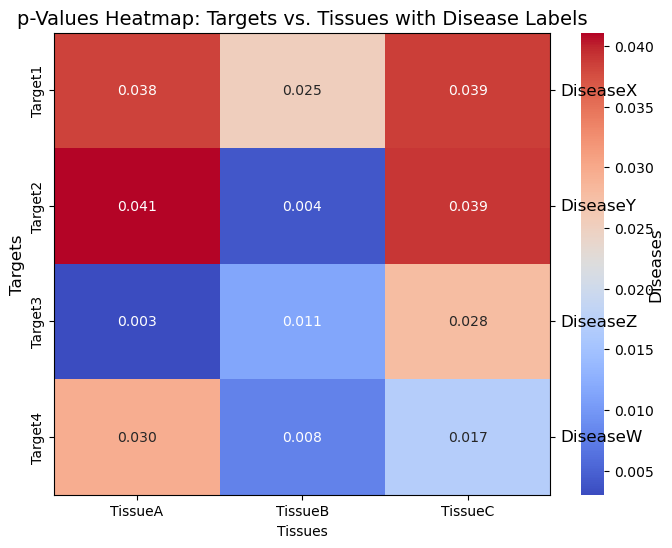

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
targets = ["Target1", "Target2", "Target3", "Target4"]
tissues = ["TissueA", "TissueB", "TissueC"]
diseases = ["DiseaseX", "DiseaseY", "DiseaseZ", "DiseaseW"]  # Matches targets

# Simulating p-values
data = np.random.rand(len(targets), len(tissues)) * 0.05
df = pd.DataFrame(data, index=targets, columns=tissues)

# 🔹 Create the heatmap
fig, ax1 = plt.subplots(figsize=(8, 6))

sns.heatmap(df, annot=True, fmt=".3f", cmap="coolwarm", cbar=True, ax=ax1)

# 🔹 Set axis labels
ax1.set_xlabel("Tissues")
ax1.set_ylabel("Targets", fontsize=12)  # Match font size

# 🔹 Create a secondary Y-axis for diseases
ax2 = ax1.twinx()
ax2.set_ylabel("Diseases", fontsize=12)  # Match label size

# ✅ Ensure disease labels match target labels
ax2.set_yticks(ax1.get_yticks())  # Align with heatmap rows
ax2.set_ylim(ax1.get_ylim())  # Ensure limits are the same
ax2.set_yticklabels(diseases, fontsize=12, va="center")  # Match font size

plt.title("p-Values Heatmap: Targets vs. Tissues with Disease Labels", fontsize=14)
plt.show()


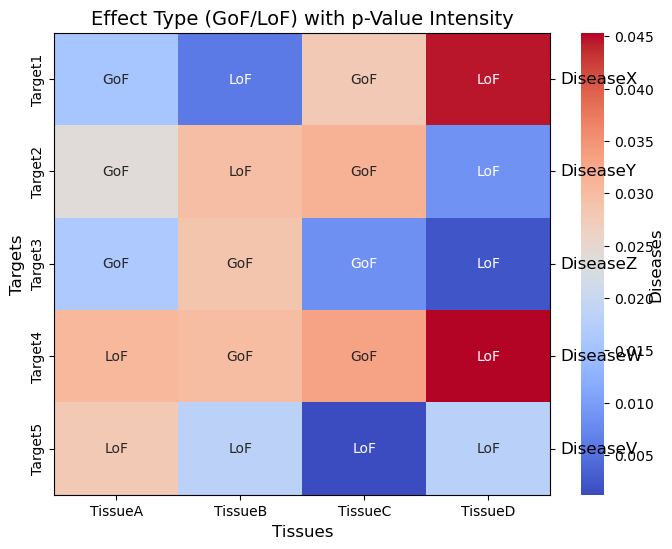

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data
targets = ["Target1", "Target2", "Target3", "Target4", "Target5"]
tissues = ["TissueA", "TissueB", "TissueC", "TissueD"]
diseases = ["DiseaseX", "DiseaseY", "DiseaseZ", "DiseaseW", "DiseaseV"]

# 🔹 Generate mock p-values for color intensity (0 to 0.05)
p_values = np.random.rand(len(targets), len(tissues)) * 0.05  

# 🔹 Randomized 'GoF' or 'LoF' with more variety
effects = np.random.choice(["GoF", "LoF"], size=(len(targets), len(tissues)), p=[0.6, 0.4])  # 60% GoF, 40% LoF

# Convert to DataFrame
df_pvals = pd.DataFrame(p_values, index=targets, columns=tissues)  # For color
df_effects = pd.DataFrame(effects, index=targets, columns=tissues)  # For text

# 🔹 Create the heatmap
fig, ax1 = plt.subplots(figsize=(8, 6))

sns.heatmap(df_pvals, annot=df_effects, fmt='', cmap="coolwarm", cbar=True, ax=ax1)

# 🔹 Set axis labels
ax1.set_xlabel("Tissues", fontsize=12)
ax1.set_ylabel("Targets", fontsize=12)

# 🔹 Create a secondary Y-axis for diseases
ax2 = ax1.twinx()
ax2.set_ylabel("Diseases", fontsize=12)

# ✅ Ensure disease labels align with targets
ax2.set_yticks(ax1.get_yticks())
ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(diseases, fontsize=12, va="center")

plt.title("Effect Type (GoF/LoF) with p-Value Intensity", fontsize=14)
plt.show()



In [15]:
path_n='gs://open-targets-data-releases/25.03/output/'

credible = spark.read.parquet(f"{path_n}credible_set")
coloc = spark.read.parquet(f"{path_n}colocalisation_coloc")
variantIndex = spark.read.parquet(f"{path_n}variant")

In [ ]:
variantIndex

In [19]:
variantIndex_old.printSchema()

root
 |-- variantId: string (nullable = true)
 |-- chromosome: string (nullable = true)
 |-- position: integer (nullable = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAllele: string (nullable = true)
 |-- inSilicoPredictors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- method: string (nullable = true)
 |    |    |-- assessment: string (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- assessmentFlag: string (nullable = true)
 |    |    |-- targetId: string (nullable = true)
 |    |    |-- normalisedScore: double (nullable = true)
 |-- mostSevereConsequenceId: string (nullable = true)
 |-- transcriptConsequences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- variantFunctionalConsequenceIds: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- aminoAcidChange: string (nullable = true)
 |    |    |-- uniprotAccess

In [20]:
variantIndex.printSchema()

root
 |-- variantId: string (nullable = true)
 |-- chromosome: string (nullable = true)
 |-- position: integer (nullable = true)
 |-- referenceAllele: string (nullable = true)
 |-- alternateAllele: string (nullable = true)
 |-- variantEffect: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- method: string (nullable = true)
 |    |    |-- assessment: string (nullable = true)
 |    |    |-- score: float (nullable = true)
 |    |    |-- assessmentFlag: string (nullable = true)
 |    |    |-- targetId: string (nullable = true)
 |    |    |-- normalisedScore: double (nullable = true)
 |-- mostSevereConsequenceId: string (nullable = true)
 |-- transcriptConsequences: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- variantFunctionalConsequenceIds: array (nullable = true)
 |    |    |    |-- element: string (containsNull = true)
 |    |    |-- aminoAcidChange: string (nullable = true)
 |    |    |-- uniprotAccessions:

In [12]:
credible.show()

+--------------------+--------------------+------------+----------+--------+--------------------+---------+------+--------------+--------------+-------------------------------+-------------+-------------------+--------------------+-----------------+----------------+------------------+------------+-----------+----------+--------+----------+--------------------+--------------------+--------------------+---------+----------+
|        studyLocusId|             studyId|   variantId|chromosome|position|              region|     beta|zScore|pValueMantissa|pValueExponent|effectAlleleFrequencyFromSource|standardError|subStudyDescription|     qualityControls|finemappingMethod|credibleSetIndex|credibleSetlog10BF|purityMeanR2|purityMinR2|locusStart|locusEnd|sampleSize|               ldSet|               locus|          confidence|studyType|isTransQtl|
+--------------------+--------------------+------------+----------+--------+--------------------+---------+------+--------------+--------------+----

In [17]:
credible = spark.read.parquet(f"{path_n}credible_set")

### index with new fix" "gs://ot-team/irene/gentropy/study_index_2412_fixed"
index = spark.read.parquet(f"gs://ot-team/irene/gentropy/study_index_2412_fixed") #### There is not such a file in the new release 25.03 version 

new = spark.read.parquet(f"{path}colocalisation/coloc")

variantIndex_old = spark.read.parquet(f"{path}variantIndex")

biosample = spark.read.parquet(f"{path}biosample")

In [1]:
#### 10.12.2024
import time
from array import ArrayType
from functions import (
    relative_success,
    spreadSheetFormatter,
    discrepancifier,
    temporary_directionOfEffect,
)
# from stoppedTrials import terminated_td
from DoEAssessment import directionOfEffect
# from membraneTargets import target_membrane
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
import pandas as pd

spark = SparkSession.builder.getOrCreate()
spark.conf.set(
    "spark.sql.shuffle.partitions", "400"
)  # Default is 200, increase if needed


path_n='gs://open-targets-data-releases/25.03/output/'

target = spark.read.parquet(f"{path_n}target/")

diseases = spark.read.parquet(f"{path_n}disease/")

evidences = spark.read.parquet(f"{path_n}evidence")

credible = spark.read.parquet(f"{path_n}credible_set")

new = spark.read.parquet(f"{path_n}colocalisation_coloc") 

index=spark.read.parquet(f"{path_n}study/")

variantIndex = spark.read.parquet(f"{path_n}variant")

biosample = spark.read.parquet(f"{path_n}biosample")

print("loaded files")

newColoc = (
    new.join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on left side
            "studyLocusId as leftStudyLocusId",
            "StudyId as leftStudyId",
            "variantId as leftVariantId",
            "studyType as credibleLeftStudyType",
        ),
        on="leftStudyLocusId",
        how="left",
    )
    .join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on right side
            "studyLocusId as rightStudyLocusId",
            "studyId as rightStudyId",
            "variantId as rightVariantId",
            "studyType as credibleRightStudyType",
            'isTransQtl'
        ),
        on="rightStudyLocusId",
        how="left",
    )
    .join(
        index.selectExpr(  ### bring modulated target on right side (QTL study)
            "studyId as rightStudyId",
            "geneId",
            "projectId",
            "studyType as indexStudyType",
            "condition",
            "biosampleId",
        ),
        on="rightStudyId",
        how="left",
)
    # .persist()
)

print("loaded newColoc")

# remove columns without content (only null values on them)
df = evidences.filter((F.col("datasourceId") == "gwas_credible_sets"))

# Use an aggregation to determine non-null columns
non_null_counts = df.select(
    *[F.sum(F.col(col).isNotNull().cast("int")).alias(col) for col in df.columns]
)

# Collect the counts for each column
non_null_columns = [
    row[0] for row in non_null_counts.collect()[0].asDict().items() if row[1] > 0
]

# Select only the non-null columns
filtered_df = df.select(*non_null_columns)  # .persist()

## bring studyId, variantId, beta from Gwas and pValue
gwasComplete = filtered_df.join(
    credible.selectExpr(
        "studyLocusId", "studyId", "variantId", "beta as betaGwas", "pValueExponent"
    ),
    on="studyLocusId",
    how="left",
)  # .persist()

print("loaded gwasComplete")

resolvedColoc = (
    (
        newColoc.withColumnRenamed("geneId", "targetId")
        .join(
            gwasComplete.withColumnRenamed("studyLocusId", "leftStudyLocusId"),
            on=["leftStudyLocusId", "targetId"],
            how="inner",
        )
        .join(  ### propagated using parent terms
            diseases.selectExpr(
                "id as diseaseId", "name", "parents", "therapeuticAreas"
            ),
            on="diseaseId",
            how="left",
        )
        .withColumn(
            "diseaseId",
            F.explode_outer(F.concat(F.array(F.col("diseaseId")), F.col("parents"))),
        )
        .drop("parents", "oldDiseaseId")
    ).withColumn(
        "colocDoE",
        F.when(
            F.col("rightStudyType").isin(
                ["eqtl", "pqtl", "tuqtl", "sceqtl", "sctuqtl"]
            ),
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_protect"),
            ),
        ).when(
            F.col("rightStudyType").isin(
                ["sqtl", "scsqtl"]
            ),  ### opposite directionality than sqtl
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_protect"),
            ),
        ),
    )
    # .persist()
)
print("loaded resolvedColloc")

datasource_filter = [
    "gwas_credible_set",
    "gene_burden",
    "eva",
    "eva_somatic",
    "gene2phenotype",
    "orphanet",
    "cancer_gene_census",
    "intogen",
    "impc",
    "chembl",
]

assessment, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)

print("run temporary direction of effect")

window_spec = Window.partitionBy("targetId", "diseaseId",'leftStudyId').orderBy( ### include gwas study
    F.col("pValueExponent").asc()
)
gwasCredibleAssoc = (
    resolvedColoc.withColumn(
        "homogenized", F.first("colocDoE", ignorenulls=True).over(window_spec)
    )  ## added 30.01.2025
    .select("targetId", "diseaseId",'leftStudyId', "homogenized")
    .withColumn(
        "homogenized",
        F.when(F.col("homogenized").isNull(), F.lit("noEvaluable")).otherwise(
            F.col("homogenized")
        ),
    )
)

print("Moving to step 2")

columns_chembl = ["LoF_protect", "GoF_protect"]
columns_dataset = ["LoF_protect", "GoF_protect", "LoF_risk", "GoF_risk", "evidenceDif"]
columns = ["GoF_risk", "LoF_protect", "LoF_risk", "GoF_protect"]
terms = ["noEvaluable", "bivalent_risk", "null", "dispar"]

taDf = spark.createDataFrame(
    data=[
        ("MONDO_0045024", "cell proliferation disorder", "Oncology"),
        ("EFO_0005741", "infectious disease", "Other"),
        ("OTAR_0000014", "pregnancy or perinatal disease", "Other"),
        ("EFO_0005932", "animal disease", "Other"),
        ("MONDO_0024458", "disease of visual system", "Other"),
        ("EFO_0000319", "cardiovascular disease", "Other"),
        ("EFO_0009605", "pancreas disease", "Other"),
        ("EFO_0010282", "gastrointestinal disease", "Other"),
        ("OTAR_0000017", "reproductive system or breast disease", "Other"),
        ("EFO_0010285", "integumentary system disease", "Other"),
        ("EFO_0001379", "endocrine system disease", "Other"),
        ("OTAR_0000010", "respiratory or thoracic disease", "Other"),
        ("EFO_0009690", "urinary system disease", "Other"),
        ("OTAR_0000006", "musculoskeletal or connective tissue disease", "Other"),
        ("MONDO_0021205", "disease of ear", "Other"),
        ("EFO_0000540", "immune system disease", "Other"),
        ("EFO_0005803", "hematologic disease", "Other"),
        ("EFO_0000618", "nervous system disease", "Other"),
        ("MONDO_0002025", "psychiatric disorder", "Other"),
        ("MONDO_0024297", "nutritional or metabolic disease", "Other"),
        ("OTAR_0000018", "genetic, familial or congenital disease", "Other"),
        ("OTAR_0000009", "injury, poisoning or other complication", "Other"),
        ("EFO_0000651", "phenotype", "Other"),
        ("EFO_0001444", "measurement", "Other"),
        ("GO_0008150", "biological process", "Other"),
    ],
    schema=StructType(
        [
            StructField("taId", StringType(), True),
            StructField("taLabel", StringType(), True),
            StructField("taLabelSimple", StringType(), True),
        ]
    ),
).withColumn("taRank", F.monotonically_increasing_id())

### give us a classification of Oncology VS non oncology
wByDisease = Window.partitionBy("diseaseId")  #### checked 31.05.2023
diseaseTA = (
    diseases.withColumn("taId", F.explode("therapeuticAreas"))
    .select(F.col("id").alias("diseaseId"), "taId", "parents")
    .join(taDf, on="taId", how="left")
    .withColumn("minRank", F.min("taRank").over(wByDisease))
    .filter(F.col("taRank") == F.col("minRank"))
    .drop("taRank", "minRank")
)

#### give us propagation of diseases and list of therapeutic areas associated
diseases2 = diseases.select("id", "parents").withColumn(
    "diseaseIdPropagated",
    F.explode_outer(F.concat(F.array(F.col("id")), F.col("parents"))),
)

chembl_trials = (
    assessment.filter((F.col("datasourceId").isin(["chembl"])))
    .groupBy("targetId", "diseaseId")
    .agg(F.max(F.col("clinicalPhase")).alias("maxClinPhase"))
)

negativeTD = (
    evidences.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "diseaseId", "studyStopReason", "studyStopReasonCategories")
    .filter(F.array_contains(F.col("studyStopReasonCategories"), "Negative"))
    .groupBy("targetId", "diseaseId")
    .count()
    .withColumn("stopReason", F.lit("Negative"))
    .drop("count")
)

assessment_all = assessment.unionByName(
    gwasCredibleAssoc.withColumn("datasourceId", F.lit("gwas_credible_set")),
    allowMissingColumns=True,
)

print("defining non propagated,propagated and analysis_drugs functions")

def analysis_nonPropagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )


def analysis_propagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .join(
            diseases2.selectExpr("id as diseaseId", "diseaseIdPropagated"),
            on="diseaseId",
            how="left",
        )
        .withColumnRenamed("diseaseId", "oldDiseaseId")
        .withColumnRenamed("diseaseIdPropagated", "diseaseId")
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )

chembl_ds = ["chembl"]

def analysis_drugs(assessment_all, chembl_ds):
    return discrepancifier(
        assessment_all.filter((F.col("datasourceId").isin(chembl_ds))
        )
        .withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase")
        .pivot("homogenized")
        .agg(F.count("targetId"))
        .persist()
    )


analysis_chembl = analysis_drugs(assessment_all, chembl_ds)

#######
## include here the analysis
#######

analysisDatasources = []

print("defining full_analysis_propagation")


def full_analysis_propagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_propagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        #### Should remove the coherencyDiagonal.isNotNull()
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )


#####
## no propag
#####
print("defining full analysis no propagation")


def full_analysis_noPropagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_nonPropagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )

print("moving to Step 3")

from functions import relative_success, spreadSheetFormatter, convertTuple
import re
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio, relative_risk

full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)
c = datetime.now()
print("starting dictionaries at", c)

#### continue here on 10.07.2024

## 1nd dictionary
dfs_dict = {}  ### checked and changed on 01.06.2023
dfs_dict_propag = {}


wocgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
]
wCgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
    "cancer_gene_census",
]

datasource_list = [
    "gene_burden",
    "intogen",
    "cancer_gene_census",
    "eva",
    "eva_somatic",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
    "WOcgc",
    "wCgc",
    "somatic",
    "germline",
]

germline_list = [
    "gene_burden",
    "eva",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
]

somatic_list = ["intogen", "cancer_gene_census", "eva_somatic"]


# assessment = prueba_assessment.filter(F.col("datasourceId").isin(datasources_analysis))
def dataset_builder(assessment_all, value, analysis_chembl, negativeTD, diseaseTA):
    nonPropagated = full_analysis_noPropagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    propagated = full_analysis_propagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    return (
        # Non propagation
        ## All
        nonPropagated,
        ## Other
        nonPropagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        nonPropagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        nonPropagated.filter(F.col("taLabelSimple") == "Oncology"),
        # Propagation
        ## All
        propagated,
        ## Other
        propagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        propagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        propagated.filter(F.col("taLabelSimple") == "Oncology"),
    )


for value in datasource_list:
    print(value)
    if value == "WOcgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wocgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "wCgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wCgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "germline":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            germline_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    elif value == "somatic":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            somatic_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    else:
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"]
        ) = dataset_builder(
            assessment_all, value, analysis_chembl, negativeTD, diseaseTA
        )


def comparisons_df() -> list:
    """Return list of all comparisons to be used in the analysis"""
    comparisons = spark.createDataFrame(
        data=[
            ("hasGeneticEvidence", "byDatatype"),
            ("diagonalYes", "byDatatype"),
            ("oneCellYes", "byDatatype"),
        ],
        schema=StructType(
            [
                StructField("comparison", StringType(), True),
                StructField("comparisonType", StringType(), True),
            ]
        ),
    )

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ("Phase>=3", "clinical"),
            ("Phase>=2", "clinical"),
            ("Phase>=1", "clinical"),
            ("PhaseT", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


result = []
result_st = []
result_ci = []
array2 = []
results = []


def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):

    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)

    uniqIds = df.select("targetId", "diseaseId").distinct().count()

    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("predictionType", F.lit(predictionType))
        .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
            "total",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    filePath = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    print(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    c = datetime.now()
    c.strftime("%H:%M:%S")
    print(c)

    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            filePath,
        ]
    )
    return results


c = datetime.now()

print("start doing aggregations and writing")
today_date = str(date.today())
aggSetups_original = comparisons_df()
listado = []
results = []


print("starting with non-propagated aggregations at", c)

for key, df in dfs_dict.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("non propagated files wroten succesfully at", c)


print("starting with propagated aggregations at", c)
for key, df in dfs_dict_propag.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("propagated files wroten succesfully at", c)

print("creating pandas dataframe with resulting rows")
df_results = pd.DataFrame(
    results,
    columns=[
        "group",
        "comparison",
        "phase",
        "OR",
        "pValue",
        "LowCI",
        "HighCI",
        "total",
        "array",
        "rs",
        "lowRs",
        "HighRs",
        "path",
    ],
)
print("created pandas dataframe")
print("converting to spark dataframe")
print("preparing dataframe")

schema = StructType(
    [
        StructField("group", StringType(), True),
        StructField("comparison", StringType(), True),
        StructField("phase", StringType(), True),
        StructField("oddsRatio", DoubleType(), True),
        StructField("pValue", DoubleType(), True),
        StructField("lowerInterval", DoubleType(), True),
        StructField("upperInterval", DoubleType(), True),
        StructField("total", StringType(), True),
        StructField("values", ArrayType(ArrayType(IntegerType())), True),
        StructField("relSuccess", DoubleType(), True),
        StructField("rsLower", DoubleType(), True),
        StructField("rsUpper", DoubleType(), True),
        StructField("path", StringType(), True),
    ]
)

print("read pattern variables")
df = spreadSheetFormatter(spark.createDataFrame(df_results, schema=schema))
print("processed spreadsheet")
print("writting the dataframe")

# Convert list of lists to DataFrame
# Regular expressions
'''
value_pattern = r"df_([^_]+)_"  # Extracts {value}
middle_pattern = r"df_[^_]+_([^_]+)_"  # Extracts middle part (All, Other, etc.)
suffix_pattern = r"(original|propag)$"  # Extracts suffix (original or propag)
'''

df.withColumn(
    "datasource",
    F.regexp_extract(F.col("group"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("group"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("group"), r"_(propag|original)$", 1)
).toPandas().to_csv(
    f"gs://ot-team/jroldan/analysis/{today_date}_genEvidAnalysis_new.csv"
)

print("dataframe written \n Analysis finished")



spark session created at 2025-04-10 08:57:06.411081
Analysis started on 2025-04-10 at  2025-04-10 08:57:06.411081


25/04/10 08:57:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


loaded files
loaded newColoc


loaded gwasComplete
loaded resolvedColloc
run temporary direction of effect
Moving to step 2
defining non propagated,propagated and analysis_drugs functions


defining full_analysis_propagation
defining full analysis no propagation
moving to Step 3
starting dictionaries at 2025-04-10 08:58:10.849351
gene_burden
intogen
cancer_gene_census
eva
eva_somatic
gwas_credible_set


impc
orphanet
gene2phenotype
WOcgc


wCgc


somatic
germline


start doing aggregations and writing


starting with non-propagated aggregations at 2025-04-10 09:01:03.236860


2025-04-10_analysis/df_gene_burden_All_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 09:01:10.468594


2025-04-10_analysis/df_gene_burden_All_original/hasGeneticEvidence_Phase>=3.parquet
2025-04-10 09:01:18.020003


2025-04-10_analysis/df_gene_burden_All_original/hasGeneticEvidence_Phase>=2.parquet
2025-04-10 09:01:25.428547


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_925_337 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_925_52 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_982_327 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_982_73 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_925_84 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_919_271 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_935_195 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_41_55 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_947_20 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpoint: No more replicas available for rdd_982_337 !
25/04/10 09:08:27 WARN BlockManagerMasterEndpo

In [ ]:
def comparisons_df() -> list:
    """Return list of all comparisons to be used in the analysis"""
    comparisons = spark.createDataFrame(
        data=[
            ("hasGeneticEvidence", "byDatatype"),
            ("diagonalYes", "byDatatype"),
            ("oneCellYes", "byDatatype"),
        ],
        schema=StructType(
            [
                StructField("comparison", StringType(), True),
                StructField("comparisonType", StringType(), True),
            ]
        ),
    )

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ("Phase>=3", "clinical"),
            ("Phase>=2", "clinical"),
            ("Phase>=1", "clinical"),
            ("PhaseT", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


result = []
result_st = []
result_ci = []
array2 = []
results = []


def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):

    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)

    uniqIds = df.select("targetId", "diseaseId").distinct().count()

    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("predictionType", F.lit(predictionType))
        .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
            "total",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    filePath = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    print(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    c = datetime.now()
    c.strftime("%H:%M:%S")
    print(c)

    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            filePath,
        ]
    )
    return results


c = datetime.now()

print("start doing aggregations and writing")
today_date = str(date.today())
aggSetups_original = comparisons_df()
listado = []
results = []


print("starting with non-propagated aggregations at", c)

for key, df in dfs_dict.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("non propagated files wroten succesfully at", c)


print("starting with propagated aggregations at", c)
for key, df in dfs_dict_propag.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("propagated files wroten succesfully at", c)

print("creating pandas dataframe with resulting rows")
df_results = pd.DataFrame(
    results,
    columns=[
        "group",
        "comparison",
        "phase",
        "OR",
        "pValue",
        "LowCI",
        "HighCI",
        "total",
        "array",
        "rs",
        "lowRs",
        "HighRs",
        "path",
    ],
)
print("created pandas dataframe")
print("converting to spark dataframe")
print("preparing dataframe")

schema = StructType(
    [
        StructField("group", StringType(), True),
        StructField("comparison", StringType(), True),
        StructField("phase", StringType(), True),
        StructField("oddsRatio", DoubleType(), True),
        StructField("pValue", DoubleType(), True),
        StructField("lowerInterval", DoubleType(), True),
        StructField("upperInterval", DoubleType(), True),
        StructField("total", StringType(), True),
        StructField("values", ArrayType(ArrayType(IntegerType())), True),
        StructField("relSuccess", DoubleType(), True),
        StructField("rsLower", DoubleType(), True),
        StructField("rsUpper", DoubleType(), True),
        StructField("path", StringType(), True),
    ]
)

print("read pattern variables")
df = spreadSheetFormatter(spark.createDataFrame(df_results, schema=schema))
print("processed spreadsheet")
print("writting the dataframe")

# Convert list of lists to DataFrame
# Regular expressions
'''
value_pattern = r"df_([^_]+)_"  # Extracts {value}
middle_pattern = r"df_[^_]+_([^_]+)_"  # Extracts middle part (All, Other, etc.)
suffix_pattern = r"(original|propag)$"  # Extracts suffix (original or propag)
'''

df.withColumn(
    "datasource",
    F.regexp_extract(F.col("group"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("group"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("group"), r"_(propag|original)$", 1)
).toPandas().to_csv(
    f"gs://ot-team/jroldan/analysis/{today_date}_genEvidAnalysis_new.csv"
)

print("dataframe written \n Analysis finished")

In [ ]:
### is gwas_credible_sets or gwas_credible_set?

In [4]:
comparisons_df()

NameError: name 'comparisons_df' is not defined

In [1]:
#### 10.12.2024
import time
from array import ArrayType
from functions import (
    relative_success,
    spreadSheetFormatter,
    discrepancifier,
    temporary_directionOfEffect,
)
# from stoppedTrials import terminated_td
from DoEAssessment import directionOfEffect
# from membraneTargets import target_membrane
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
import pandas as pd

spark = SparkSession.builder.getOrCreate()
spark.conf.set(
    "spark.sql.shuffle.partitions", "400"
)  # Default is 200, increase if needed


path_n='gs://open-targets-data-releases/25.03/output/'

target = spark.read.parquet(f"{path_n}target/")

diseases = spark.read.parquet(f"{path_n}disease/")

evidences = spark.read.parquet(f"{path_n}evidence")

credible = spark.read.parquet(f"{path_n}credible_set")

new = spark.read.parquet(f"{path_n}colocalisation_coloc") 

index=spark.read.parquet(f"{path_n}study/")

variantIndex = spark.read.parquet(f"{path_n}variant")

biosample = spark.read.parquet(f"{path_n}biosample")

print("loaded files")

newColoc = (
    new.join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on left side
            "studyLocusId as leftStudyLocusId",
            "StudyId as leftStudyId",
            "variantId as leftVariantId",
            "studyType as credibleLeftStudyType",
        ),
        on="leftStudyLocusId",
        how="left",
    )
    .join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on right side
            "studyLocusId as rightStudyLocusId",
            "studyId as rightStudyId",
            "variantId as rightVariantId",
            "studyType as credibleRightStudyType",
            'isTransQtl'
        ),
        on="rightStudyLocusId",
        how="left",
    )
    .join(
        index.selectExpr(  ### bring modulated target on right side (QTL study)
            "studyId as rightStudyId",
            "geneId",
            "projectId",
            "studyType as indexStudyType",
            "condition",
            "biosampleId",
        ),
        on="rightStudyId",
        how="left",
)
    # .persist()
)

print("loaded newColoc")

# remove columns without content (only null values on them)
df = evidences.filter((F.col("datasourceId") == "gwas_credible_sets"))

# Use an aggregation to determine non-null columns
non_null_counts = df.select(
    *[F.sum(F.col(col).isNotNull().cast("int")).alias(col) for col in df.columns]
)

# Collect the counts for each column
non_null_columns = [
    row[0] for row in non_null_counts.collect()[0].asDict().items() if row[1] > 0
]

# Select only the non-null columns
filtered_df = df.select(*non_null_columns)  # .persist()

## bring studyId, variantId, beta from Gwas and pValue
gwasComplete = filtered_df.join(
    credible.selectExpr(
        "studyLocusId", "studyId", "variantId", "beta as betaGwas", "pValueExponent"
    ),
    on="studyLocusId",
    how="left",
)  # .persist()

print("loaded gwasComplete")

resolvedColoc = (
    (
        newColoc.withColumnRenamed("geneId", "targetId")
        .join(
            gwasComplete.withColumnRenamed("studyLocusId", "leftStudyLocusId"),
            on=["leftStudyLocusId", "targetId"],
            how="inner",
        )
        .join(  ### propagated using parent terms
            diseases.selectExpr(
                "id as diseaseId", "name", "parents", "therapeuticAreas"
            ),
            on="diseaseId",
            how="left",
        )
        .withColumn(
            "diseaseId",
            F.explode_outer(F.concat(F.array(F.col("diseaseId")), F.col("parents"))),
        )
        .drop("parents", "oldDiseaseId")
    ).withColumn(
        "colocDoE",
        F.when(
            F.col("rightStudyType").isin(
                ["eqtl", "pqtl", "tuqtl", "sceqtl", "sctuqtl"]
            ),
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_protect"),
            ),
        ).when(
            F.col("rightStudyType").isin(
                ["sqtl", "scsqtl"]
            ),  ### opposite directionality than sqtl
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_protect"),
            ),
        ),
    )
    # .persist()
)
print("loaded resolvedColloc")

datasource_filter = [
    "gwas_credible_set",
    "gene_burden",
    "eva",
    "eva_somatic",
    "gene2phenotype",
    "orphanet",
    "cancer_gene_census",
    "intogen",
    "impc",
    "chembl",
]

assessment, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)

print("run temporary direction of effect")

window_spec = Window.partitionBy("targetId", "diseaseId",'leftStudyId').orderBy( ### include gwas study
    F.col("pValueExponent").asc()
)
gwasCredibleAssoc = (
    resolvedColoc.withColumn(
        "homogenized", F.first("colocDoE", ignorenulls=True).over(window_spec)
    )  ## added 30.01.2025
    .select("targetId", "diseaseId",'leftStudyId', "homogenized")
    .withColumn(
        "homogenized",
        F.when(F.col("homogenized").isNull(), F.lit("noEvaluable")).otherwise(
            F.col("homogenized")
        ),
    )
)

print("Moving to step 2")

columns_chembl = ["LoF_protect", "GoF_protect"]
columns_dataset = ["LoF_protect", "GoF_protect", "LoF_risk", "GoF_risk", "evidenceDif"]
columns = ["GoF_risk", "LoF_protect", "LoF_risk", "GoF_protect"]
terms = ["noEvaluable", "bivalent_risk", "null", "dispar"]

taDf = spark.createDataFrame(
    data=[
        ("MONDO_0045024", "cell proliferation disorder", "Oncology"),
        ("EFO_0005741", "infectious disease", "Other"),
        ("OTAR_0000014", "pregnancy or perinatal disease", "Other"),
        ("EFO_0005932", "animal disease", "Other"),
        ("MONDO_0024458", "disease of visual system", "Other"),
        ("EFO_0000319", "cardiovascular disease", "Other"),
        ("EFO_0009605", "pancreas disease", "Other"),
        ("EFO_0010282", "gastrointestinal disease", "Other"),
        ("OTAR_0000017", "reproductive system or breast disease", "Other"),
        ("EFO_0010285", "integumentary system disease", "Other"),
        ("EFO_0001379", "endocrine system disease", "Other"),
        ("OTAR_0000010", "respiratory or thoracic disease", "Other"),
        ("EFO_0009690", "urinary system disease", "Other"),
        ("OTAR_0000006", "musculoskeletal or connective tissue disease", "Other"),
        ("MONDO_0021205", "disease of ear", "Other"),
        ("EFO_0000540", "immune system disease", "Other"),
        ("EFO_0005803", "hematologic disease", "Other"),
        ("EFO_0000618", "nervous system disease", "Other"),
        ("MONDO_0002025", "psychiatric disorder", "Other"),
        ("MONDO_0024297", "nutritional or metabolic disease", "Other"),
        ("OTAR_0000018", "genetic, familial or congenital disease", "Other"),
        ("OTAR_0000009", "injury, poisoning or other complication", "Other"),
        ("EFO_0000651", "phenotype", "Other"),
        ("EFO_0001444", "measurement", "Other"),
        ("GO_0008150", "biological process", "Other"),
    ],
    schema=StructType(
        [
            StructField("taId", StringType(), True),
            StructField("taLabel", StringType(), True),
            StructField("taLabelSimple", StringType(), True),
        ]
    ),
).withColumn("taRank", F.monotonically_increasing_id())

### give us a classification of Oncology VS non oncology
wByDisease = Window.partitionBy("diseaseId")  #### checked 31.05.2023
diseaseTA = (
    diseases.withColumn("taId", F.explode("therapeuticAreas"))
    .select(F.col("id").alias("diseaseId"), "taId", "parents")
    .join(taDf, on="taId", how="left")
    .withColumn("minRank", F.min("taRank").over(wByDisease))
    .filter(F.col("taRank") == F.col("minRank"))
    .drop("taRank", "minRank")
)

#### give us propagation of diseases and list of therapeutic areas associated
diseases2 = diseases.select("id", "parents").withColumn(
    "diseaseIdPropagated",
    F.explode_outer(F.concat(F.array(F.col("id")), F.col("parents"))),
)

chembl_trials = (
    assessment.filter((F.col("datasourceId").isin(["chembl"])))
    .groupBy("targetId", "diseaseId")
    .agg(F.max(F.col("clinicalPhase")).alias("maxClinPhase"))
)

negativeTD = (
    evidences.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "diseaseId", "studyStopReason", "studyStopReasonCategories")
    .filter(F.array_contains(F.col("studyStopReasonCategories"), "Negative"))
    .groupBy("targetId", "diseaseId")
    .count()
    .withColumn("stopReason", F.lit("Negative"))
    .drop("count")
)

assessment_all = assessment.unionByName(
    gwasCredibleAssoc.withColumn("datasourceId", F.lit("gwas_credible_set")),
    allowMissingColumns=True,
)

print("defining non propagated,propagated and analysis_drugs functions")

def analysis_nonPropagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )


def analysis_propagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .join(
            diseases2.selectExpr("id as diseaseId", "diseaseIdPropagated"),
            on="diseaseId",
            how="left",
        )
        .withColumnRenamed("diseaseId", "oldDiseaseId")
        .withColumnRenamed("diseaseIdPropagated", "diseaseId")
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )

chembl_ds = ["chembl"]

def analysis_drugs(assessment_all, chembl_ds):
    return discrepancifier(
        assessment_all.filter((F.col("datasourceId").isin(chembl_ds))
        )
        .withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase")
        .pivot("homogenized")
        .agg(F.count("targetId"))
        .persist()
    )


analysis_chembl = analysis_drugs(assessment_all, chembl_ds)

#######
## include here the analysis
#######

analysisDatasources = []

print("defining full_analysis_propagation")


def full_analysis_propagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_propagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        #### Should remove the coherencyDiagonal.isNotNull()
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )


#####
## no propag
#####
print("defining full analysis no propagation")


def full_analysis_noPropagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_nonPropagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )

print("moving to Step 3")

from functions import relative_success, spreadSheetFormatter, convertTuple
import re
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio, relative_risk

full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)
c = datetime.now()
print("starting dictionaries at", c)

#### continue here on 10.07.2024

## 1nd dictionary
dfs_dict = {}  ### checked and changed on 01.06.2023
dfs_dict_propag = {}


wocgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
]
wCgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
    "cancer_gene_census",
]

datasource_list = [
    "gene_burden",
    "intogen",
    "cancer_gene_census",
    "eva",
    "eva_somatic",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
    "WOcgc",
    "wCgc",
    "somatic",
    "germline",
]

germline_list = [
    "gene_burden",
    "eva",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
]

somatic_list = ["intogen", "cancer_gene_census", "eva_somatic"]


# assessment = prueba_assessment.filter(F.col("datasourceId").isin(datasources_analysis))
def dataset_builder(assessment_all, value, analysis_chembl, negativeTD, diseaseTA):
    nonPropagated = full_analysis_noPropagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    propagated = full_analysis_propagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    return (
        # Non propagation
        ## All
        nonPropagated,
        ## Other
        nonPropagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        nonPropagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        nonPropagated.filter(F.col("taLabelSimple") == "Oncology"),
        # Propagation
        ## All
        propagated,
        ## Other
        propagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        propagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        propagated.filter(F.col("taLabelSimple") == "Oncology"),
    )


for value in datasource_list:
    print(value)
    if value == "WOcgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wocgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "wCgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wCgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "germline":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            germline_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    elif value == "somatic":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            somatic_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    else:
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"]
        ) = dataset_builder(
            assessment_all, value, analysis_chembl, negativeTD, diseaseTA
        )


def comparisons_df() -> list:
    """Return list of all comparisons to be used in the analysis"""
    comparisons = spark.createDataFrame(
        data=[
            ("hasGeneticEvidence", "byDatatype"),
            ("diagonalYes", "byDatatype"),
            ("oneCellYes", "byDatatype"),
        ],
        schema=StructType(
            [
                StructField("comparison", StringType(), True),
                StructField("comparisonType", StringType(), True),
            ]
        ),
    )

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ("Phase>=3", "clinical"),
            ("Phase>=2", "clinical"),
            ("Phase>=1", "clinical"),
            ("PhaseT", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


result = []
result_st = []
result_ci = []
array2 = []
results = []


def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):

    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)

    uniqIds = df.select("targetId", "diseaseId").distinct().count()

    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("predictionType", F.lit(predictionType))
        .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
            "total",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    filePath = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    print(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    c = datetime.now()
    c.strftime("%H:%M:%S")
    print(c)

    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            filePath,
        ]
    )
    return results


spark session created at 2025-04-10 13:23:21.978333
Analysis started on 2025-04-10 at  2025-04-10 13:23:21.978333


25/04/10 13:23:27 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


loaded files
loaded newColoc


loaded gwasComplete
loaded resolvedColloc
run temporary direction of effect
Moving to step 2
defining non propagated,propagated and analysis_drugs functions


defining full_analysis_propagation
defining full analysis no propagation
moving to Step 3
starting dictionaries at 2025-04-10 13:24:34.323189
gene_burden
intogen
cancer_gene_census
eva
eva_somatic
gwas_credible_set


impc
orphanet
gene2phenotype
WOcgc


wCgc


somatic
germline


In [ ]:
c = datetime.now()

print("start doing aggregations and writing")
today_date = str(date.today())
aggSetups_original = comparisons_df()
listado = []
results = []


print("starting with non-propagated aggregations at", c)

for key, df in dfs_dict.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("non propagated files wroten succesfully at", c)


print("starting with propagated aggregations at", c)
for key, df in dfs_dict_propag.items():
    df = df.persist()
    for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("propagated files wroten succesfully at", c)

print("creating pandas dataframe with resulting rows")
df_results = pd.DataFrame(
    results,
    columns=[
        "group",
        "comparison",
        "phase",
        "OR",
        "pValue",
        "LowCI",
        "HighCI",
        "total",
        "array",
        "rs",
        "lowRs",
        "HighRs",
        "path",
    ],
)
print("created pandas dataframe")
print("converting to spark dataframe")
print("preparing dataframe")

schema = StructType(
    [
        StructField("group", StringType(), True),
        StructField("comparison", StringType(), True),
        StructField("phase", StringType(), True),
        StructField("oddsRatio", DoubleType(), True),
        StructField("pValue", DoubleType(), True),
        StructField("lowerInterval", DoubleType(), True),
        StructField("upperInterval", DoubleType(), True),
        StructField("total", StringType(), True),
        StructField("values", ArrayType(ArrayType(IntegerType())), True),
        StructField("relSuccess", DoubleType(), True),
        StructField("rsLower", DoubleType(), True),
        StructField("rsUpper", DoubleType(), True),
        StructField("path", StringType(), True),
    ]
)

print("read pattern variables")
df = spreadSheetFormatter(spark.createDataFrame(df_results, schema=schema))
print("processed spreadsheet")
print("writting the dataframe")

# Convert list of lists to DataFrame
# Regular expressions
'''
value_pattern = r"df_([^_]+)_"  # Extracts {value}
middle_pattern = r"df_[^_]+_([^_]+)_"  # Extracts middle part (All, Other, etc.)
suffix_pattern = r"(original|propag)$"  # Extracts suffix (original or propag)
'''

df.withColumn(
    "datasource",
    F.regexp_extract(F.col("group"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("group"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("group"), r"_(propag|original)$", 1)
).toPandas().to_csv(
    f"gs://ot-team/jroldan/analysis/{today_date}_genEvidAnalysis_new.csv"
)

print("dataframe written \n Analysis finished")

In [8]:
aggSetups_original = comparisons_df()

In [9]:
aggSetups_original

[Row(comparison='hasGeneticEvidence', comparisonType='byDatatype', _1='Phase4', _2='clinical'),
 Row(comparison='hasGeneticEvidence', comparisonType='byDatatype', _1='Phase>=3', _2='clinical'),
 Row(comparison='hasGeneticEvidence', comparisonType='byDatatype', _1='Phase>=2', _2='clinical'),
 Row(comparison='hasGeneticEvidence', comparisonType='byDatatype', _1='Phase>=1', _2='clinical'),
 Row(comparison='hasGeneticEvidence', comparisonType='byDatatype', _1='PhaseT', _2='clinical'),
 Row(comparison='diagonalYes', comparisonType='byDatatype', _1='Phase4', _2='clinical'),
 Row(comparison='diagonalYes', comparisonType='byDatatype', _1='Phase>=3', _2='clinical'),
 Row(comparison='diagonalYes', comparisonType='byDatatype', _1='Phase>=2', _2='clinical'),
 Row(comparison='diagonalYes', comparisonType='byDatatype', _1='Phase>=1', _2='clinical'),
 Row(comparison='diagonalYes', comparisonType='byDatatype', _1='PhaseT', _2='clinical'),
 Row(comparison='oneCellYes', comparisonType='byDatatype', _1='

In [ ]:
for row in aggSetups_original:
        aggregations_original(df, key, listado, *row, today_date)

In [6]:
for key, df in dfs_dict_propag.items():
    print(key, df.select("targetId", "diseaseId").distinct().count())

df_gene_burden_All_propag 74197
df_gene_burden_Other_propag 37704
df_gene_burden_OtherNull_propag 38407
df_gene_burden_Oncology_propag 35790
df_intogen_All_propag 74197
df_intogen_Other_propag 37704
df_intogen_OtherNull_propag 38407
df_intogen_Oncology_propag 35790
df_cancer_gene_census_All_propag 74197
df_cancer_gene_census_Other_propag 37704
df_cancer_gene_census_OtherNull_propag 38407
df_cancer_gene_census_Oncology_propag 35790
df_eva_All_propag 74197
df_eva_Other_propag 37704
df_eva_OtherNull_propag 38407
df_eva_Oncology_propag 35790
df_eva_somatic_All_propag 74197
df_eva_somatic_Other_propag 37704
df_eva_somatic_OtherNull_propag 38407
df_eva_somatic_Oncology_propag 35790
df_gwas_credible_set_All_propag 74197


df_gwas_credible_set_Other_propag 37704
df_gwas_credible_set_OtherNull_propag 38407
df_gwas_credible_set_Oncology_propag 35790
df_impc_All_propag 74197


df_impc_Other_propag 37704


df_impc_OtherNull_propag 38407


df_impc_Oncology_propag 35790
df_orphanet_All_propag 74197
df_orphanet_Other_propag 37704
df_orphanet_OtherNull_propag 38407
df_orphanet_Oncology_propag 35790
df_gene2phenotype_All_propag 74197
df_gene2phenotype_Other_propag 37704
df_gene2phenotype_OtherNull_propag 38407
df_gene2phenotype_Oncology_propag 35790
df_WOcgc_All_propag 74197
df_WOcgc_Other_propag 37704
df_WOcgc_OtherNull_propag 38407
df_WOcgc_Oncology_propag 35790
df_wCgc_All_propag 74197
df_wCgc_Other_propag 37704
df_wCgc_OtherNull_propag 38407
df_wCgc_Oncology_propag 35790
df_somatic_All_propag 74197
df_somatic_Other_propag 37704
df_somatic_OtherNull_propag 38407
df_somatic_Oncology_propag 35790
df_germline_All_propag 74197
df_germline_Other_propag 37704
df_germline_OtherNull_propag 38407
df_germline_Oncology_propag 35790


In [ ]:
#### 10.12.2024
import time
from array import ArrayType
from functions import (
    relative_success,
    spreadSheetFormatter,
    discrepancifier,
    temporary_directionOfEffect,
)
# from stoppedTrials import terminated_td
from DoEAssessment import directionOfEffect
# from membraneTargets import target_membrane
from pyspark.sql import SparkSession, Window
import pyspark.sql.functions as F
from datetime import datetime
from datetime import date
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import (
    StructType,
    StructField,
    DoubleType,
    DecimalType,
    StringType,
    FloatType,
)
import pandas as pd

spark = SparkSession.builder.getOrCreate()
spark.conf.set(
    "spark.sql.shuffle.partitions", "400"
)  # Default is 200, increase if needed


path_n='gs://open-targets-data-releases/25.03/output/'

target = spark.read.parquet(f"{path_n}target/")

diseases = spark.read.parquet(f"{path_n}disease/")

evidences = spark.read.parquet(f"{path_n}evidence")

credible = spark.read.parquet(f"{path_n}credible_set")

new = spark.read.parquet(f"{path_n}colocalisation_coloc") 

index=spark.read.parquet(f"{path_n}study/")

variantIndex = spark.read.parquet(f"{path_n}variant")

biosample = spark.read.parquet(f"{path_n}biosample")

print("loaded files")

newColoc = (
    new.join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on left side
            "studyLocusId as leftStudyLocusId",
            "StudyId as leftStudyId",
            "variantId as leftVariantId",
            "studyType as credibleLeftStudyType",
        ),
        on="leftStudyLocusId",
        how="left",
    )
    .join(
        credible.selectExpr(  #### studyLocusId from credible set to uncover the codified variants on right side
            "studyLocusId as rightStudyLocusId",
            "studyId as rightStudyId",
            "variantId as rightVariantId",
            "studyType as credibleRightStudyType",
            'isTransQtl'
        ),
        on="rightStudyLocusId",
        how="left",
    )
    .join(
        index.selectExpr(  ### bring modulated target on right side (QTL study)
            "studyId as rightStudyId",
            "geneId",
            "projectId",
            "studyType as indexStudyType",
            "condition",
            "biosampleId",
        ),
        on="rightStudyId",
        how="left",
)
    # .persist()
)

print("loaded newColoc")

# remove columns without content (only null values on them)
df = evidences.filter((F.col("datasourceId") == "gwas_credible_sets"))

# Use an aggregation to determine non-null columns
non_null_counts = df.select(
    *[F.sum(F.col(col).isNotNull().cast("int")).alias(col) for col in df.columns]
)

# Collect the counts for each column
non_null_columns = [
    row[0] for row in non_null_counts.collect()[0].asDict().items() if row[1] > 0
]

# Select only the non-null columns
filtered_df = df.select(*non_null_columns)  # .persist()

## bring studyId, variantId, beta from Gwas and pValue
gwasComplete = filtered_df.join(
    credible.selectExpr(
        "studyLocusId", "studyId", "variantId", "beta as betaGwas", "pValueExponent"
    ),
    on="studyLocusId",
    how="left",
)  # .persist()

print("loaded gwasComplete")

resolvedColoc = (
    (
        newColoc.withColumnRenamed("geneId", "targetId")
        .join(
            gwasComplete.withColumnRenamed("studyLocusId", "leftStudyLocusId"),
            on=["leftStudyLocusId", "targetId"],
            how="inner",
        )
        .join(  ### propagated using parent terms
            diseases.selectExpr(
                "id as diseaseId", "name", "parents", "therapeuticAreas"
            ),
            on="diseaseId",
            how="left",
        )
        .withColumn(
            "diseaseId",
            F.explode_outer(F.concat(F.array(F.col("diseaseId")), F.col("parents"))),
        )
        .drop("parents", "oldDiseaseId")
    ).withColumn(
        "colocDoE",
        F.when(
            F.col("rightStudyType").isin(
                ["eqtl", "pqtl", "tuqtl", "sceqtl", "sctuqtl"]
            ),
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_protect"),
            ),
        ).when(
            F.col("rightStudyType").isin(
                ["sqtl", "scsqtl"]
            ),  ### opposite directionality than sqtl
            F.when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("LoF_risk"),
            )
            .when(
                (F.col("betaGwas") > 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("GoF_risk"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") > 0),
                F.lit("GoF_protect"),
            )
            .when(
                (F.col("betaGwas") < 0) & (F.col("betaRatioSignAverage") < 0),
                F.lit("LoF_protect"),
            ),
        ),
    )
    # .persist()
)
print("loaded resolvedColloc")

datasource_filter = [
    "gwas_credible_set",
    "gene_burden",
    "eva",
    "eva_somatic",
    "gene2phenotype",
    "orphanet",
    "cancer_gene_census",
    "intogen",
    "impc",
    "chembl",
]

assessment, evidences, actionType, oncolabel = temporary_directionOfEffect(
    path_n, datasource_filter
)

print("run temporary direction of effect")

window_spec = Window.partitionBy("targetId", "diseaseId",'leftStudyId').orderBy( ### include gwas study
    F.col("pValueExponent").asc()
)
gwasCredibleAssoc = (
    resolvedColoc.withColumn(
        "homogenized", F.first("colocDoE", ignorenulls=True).over(window_spec)
    )  ## added 30.01.2025
    .select("targetId", "diseaseId",'leftStudyId', "homogenized")
    .withColumn(
        "homogenized",
        F.when(F.col("homogenized").isNull(), F.lit("noEvaluable")).otherwise(
            F.col("homogenized")
        ),
    )
)

print("Moving to step 2")

columns_chembl = ["LoF_protect", "GoF_protect"]
columns_dataset = ["LoF_protect", "GoF_protect", "LoF_risk", "GoF_risk", "evidenceDif"]
columns = ["GoF_risk", "LoF_protect", "LoF_risk", "GoF_protect"]
terms = ["noEvaluable", "bivalent_risk", "null", "dispar"]

taDf = spark.createDataFrame(
    data=[
        ("MONDO_0045024", "cell proliferation disorder", "Oncology"),
        ("EFO_0005741", "infectious disease", "Other"),
        ("OTAR_0000014", "pregnancy or perinatal disease", "Other"),
        ("EFO_0005932", "animal disease", "Other"),
        ("MONDO_0024458", "disease of visual system", "Other"),
        ("EFO_0000319", "cardiovascular disease", "Other"),
        ("EFO_0009605", "pancreas disease", "Other"),
        ("EFO_0010282", "gastrointestinal disease", "Other"),
        ("OTAR_0000017", "reproductive system or breast disease", "Other"),
        ("EFO_0010285", "integumentary system disease", "Other"),
        ("EFO_0001379", "endocrine system disease", "Other"),
        ("OTAR_0000010", "respiratory or thoracic disease", "Other"),
        ("EFO_0009690", "urinary system disease", "Other"),
        ("OTAR_0000006", "musculoskeletal or connective tissue disease", "Other"),
        ("MONDO_0021205", "disease of ear", "Other"),
        ("EFO_0000540", "immune system disease", "Other"),
        ("EFO_0005803", "hematologic disease", "Other"),
        ("EFO_0000618", "nervous system disease", "Other"),
        ("MONDO_0002025", "psychiatric disorder", "Other"),
        ("MONDO_0024297", "nutritional or metabolic disease", "Other"),
        ("OTAR_0000018", "genetic, familial or congenital disease", "Other"),
        ("OTAR_0000009", "injury, poisoning or other complication", "Other"),
        ("EFO_0000651", "phenotype", "Other"),
        ("EFO_0001444", "measurement", "Other"),
        ("GO_0008150", "biological process", "Other"),
    ],
    schema=StructType(
        [
            StructField("taId", StringType(), True),
            StructField("taLabel", StringType(), True),
            StructField("taLabelSimple", StringType(), True),
        ]
    ),
).withColumn("taRank", F.monotonically_increasing_id())

### give us a classification of Oncology VS non oncology
wByDisease = Window.partitionBy("diseaseId")  #### checked 31.05.2023
diseaseTA = (
    diseases.withColumn("taId", F.explode("therapeuticAreas"))
    .select(F.col("id").alias("diseaseId"), "taId", "parents")
    .join(taDf, on="taId", how="left")
    .withColumn("minRank", F.min("taRank").over(wByDisease))
    .filter(F.col("taRank") == F.col("minRank"))
    .drop("taRank", "minRank")
)

#### give us propagation of diseases and list of therapeutic areas associated
diseases2 = diseases.select("id", "parents").withColumn(
    "diseaseIdPropagated",
    F.explode_outer(F.concat(F.array(F.col("id")), F.col("parents"))),
)

chembl_trials = (
    assessment.filter((F.col("datasourceId").isin(["chembl"])))
    .groupBy("targetId", "diseaseId")
    .agg(F.max(F.col("clinicalPhase")).alias("maxClinPhase"))
)

negativeTD = (
    evidences.filter(F.col("datasourceId") == "chembl")
    .select("targetId", "diseaseId", "studyStopReason", "studyStopReasonCategories")
    .filter(F.array_contains(F.col("studyStopReasonCategories"), "Negative"))
    .groupBy("targetId", "diseaseId")
    .count()
    .withColumn("stopReason", F.lit("Negative"))
    .drop("count")
)

assessment_all = assessment.unionByName(
    gwasCredibleAssoc.withColumn("datasourceId", F.lit("gwas_credible_set")),
    allowMissingColumns=True,
)

print("defining non propagated,propagated and analysis_drugs functions")

def analysis_nonPropagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )


def analysis_propagated(assessment_all, analysisDatasources):
    return discrepancifier(
        assessment_all.filter(F.col("datasourceId").isin(analysisDatasources))
        .withColumn(
            "datasources",
            F.collect_set(F.col("datasourceId")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .join(
            diseases2.selectExpr("id as diseaseId", "diseaseIdPropagated"),
            on="diseaseId",
            how="left",
        )
        .withColumnRenamed("diseaseId", "oldDiseaseId")
        .withColumnRenamed("diseaseIdPropagated", "diseaseId")
        .groupBy(
            "targetId",
            "diseaseId",
        )
        .pivot("homogenized")
        .agg(F.count("targetId"))
        # .persist()
    )

chembl_ds = ["chembl"]

def analysis_drugs(assessment_all, chembl_ds):
    return discrepancifier(
        assessment_all.filter((F.col("datasourceId").isin(chembl_ds))
        )
        .withColumn(
            "maxClinPhase",
            F.max(F.col("clinicalPhase")).over(
                Window.partitionBy("targetId", "diseaseId")
            ),
        )
        .groupBy("targetId", "diseaseId", "maxClinPhase")
        .pivot("homogenized")
        .agg(F.count("targetId"))
        .persist()
    )


analysis_chembl = analysis_drugs(assessment_all, chembl_ds)

#######
## include here the analysis
#######

analysisDatasources = []

print("defining full_analysis_propagation")


def full_analysis_propagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_propagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        #### Should remove the coherencyDiagonal.isNotNull()
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )


#####
## no propag
#####
print("defining full analysis no propagation")


def full_analysis_noPropagation(
    assessment_all, analysisDatasources, analysis_chembl, negativeTD, diseaseTA
):
    return (
        analysis_nonPropagated(assessment_all, analysisDatasources)
        .join(
            analysis_chembl.selectExpr(
                "targetId",
                "diseaseId",
                "maxClinPhase",
                "coherencyDiagonal as coherencyDiagonal_ch",
                "coherencyOneCell as coherencyOneCell_ch",
                "LoF_protect as LoF_protect_ch",
                "GoF_protect as GoF_protect_ch",
            ),
            on=["targetId", "diseaseId"],
            how="right",
        )
        .withColumn(
            "geneticEvidence",
            F.when(
                F.col("coherencyDiagonal").isNotNull(), F.lit("hasGeneticEvidence")
            ).otherwise(F.lit("noGeneticEvidence")),
        )
        # .filter(F.col("coherencyDiagonal_ch").isNotNull())
        .withColumn(
            "diagonalAgreeWithDrugs",
            F.when(
                (F.col("coherencyDiagonal_ch") == "coherent")
                & (F.col("coherencyDiagonal") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        F.col("GoF_risk").isNotNull() | F.col("LoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .when(
                    F.col("GoF_protect_ch").isNotNull()
                    & (
                        F.col("LoF_risk").isNotNull() | F.col("GoF_protect").isNotNull()
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "oneCellAgreeWithDrugs",
            F.when(
                (F.col("coherencyOneCell_ch") == "coherent")
                & (F.col("coherencyOneCell") == "coherent"),
                F.when(
                    (F.col("LoF_protect_ch").isNotNull())
                    & (
                        (F.col("LoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("GoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .when(
                    (F.col("GoF_protect_ch").isNotNull())
                    & (
                        (F.col("GoF_protect").isNotNull())
                        & (F.col("LoF_risk").isNull())
                        & (F.col("LoF_protect").isNull())
                        & (F.col("GoF_risk").isNull())
                    ),
                    F.lit("coherent"),
                )
                .otherwise(F.lit("dispar")),
            ),
        )
        .withColumn(
            "Phase4",
            F.when(F.col("maxClinPhase") == 4, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=3",
            F.when(F.col("maxClinPhase") >= 3, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=2",
            F.when(F.col("maxClinPhase") >= 2, F.lit("yes")).otherwise(F.lit("no")),
        )
        .withColumn(
            "Phase>=1",
            F.when(F.col("maxClinPhase") >= 1, F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(negativeTD, on=["targetId", "diseaseId"], how="left")
        .withColumn(
            "PhaseT",
            F.when(F.col("stopReason") == "Negative", F.lit("yes")).otherwise(F.lit("no")),
        )
        .join(
            diseaseTA.select("diseaseId", "taLabelSimple"), on="diseaseId", how="left"
        )
        .withColumn(
            "hasGeneticEvidence",
            F.when(
                F.col("geneticEvidence") == "hasGeneticEvidence", F.lit("yes")
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "diagonalYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("diagonalAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("diagonalAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        .withColumn(
            "oneCellYes",
            F.when(
                F.col("hasGeneticEvidence") == "yes",
                F.when(F.col("oneCellAgreeWithDrugs") == "coherent", F.lit("yes"))
                .when(F.col("oneCellAgreeWithDrugs") == "dispar", F.lit("no"))
                .otherwise(F.lit("no")),
            ).otherwise(F.lit("no")),
        )
        # .persist()
    )

print("moving to Step 3")

from functions import relative_success, spreadSheetFormatter, convertTuple
import re
import pandas as pd
import numpy as np
from scipy.stats import fisher_exact
from scipy.stats.contingency import odds_ratio, relative_risk

full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)
c = datetime.now()
print("starting dictionaries at", c)

#### continue here on 10.07.2024

## 1nd dictionary
dfs_dict = {}  ### checked and changed on 01.06.2023
dfs_dict_propag = {}


wocgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
]
wCgc_list = [
    "gene_burden",
    "intogen",
    "eva",
    "eva_somatic",
    "impc",
    "orphanet",
    "gene2phenotype",
    "gwas_credible_set",
    "cancer_gene_census",
]

datasource_list = [
    "gene_burden",
    "intogen",
    "cancer_gene_census",
    "eva",
    "eva_somatic",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
    "WOcgc",
    "wCgc",
    "somatic",
    "germline",
]

germline_list = [
    "gene_burden",
    "eva",
    "gwas_credible_set",
    "impc",
    "orphanet",
    "gene2phenotype",
]

somatic_list = ["intogen", "cancer_gene_census", "eva_somatic"]


# assessment = prueba_assessment.filter(F.col("datasourceId").isin(datasources_analysis))
def dataset_builder(assessment_all, value, analysis_chembl, negativeTD, diseaseTA):
    nonPropagated = full_analysis_noPropagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    propagated = full_analysis_propagation(
        assessment_all, value, analysis_chembl, negativeTD, diseaseTA
    )
    return (
        # Non propagation
        ## All
        nonPropagated,
        ## Other
        nonPropagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        nonPropagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        nonPropagated.filter(F.col("taLabelSimple") == "Oncology"),
        # Propagation
        ## All
        propagated,
        ## Other
        propagated.filter(F.col("taLabelSimple") == "Other"),
        ## Other&Null
        propagated.filter(
            (F.col("taLabelSimple").isNull()) | (F.col("taLabelSimple") == "Other")
        ),
        ## Oncology
        propagated.filter(F.col("taLabelSimple") == "Oncology"),
    )


for value in datasource_list:
    print(value)
    if value == "WOcgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wocgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "wCgc":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all, wCgc_list, analysis_chembl, negativeTD, diseaseTA
        )
    elif value == "germline":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            germline_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    elif value == "somatic":
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"],
        ) = dataset_builder(
            assessment_all,
            somatic_list,
            analysis_chembl,
            negativeTD,
            diseaseTA,
        )

    else:
        (
            dfs_dict[f"df_{value}_All_original"],
            dfs_dict[f"df_{value}_Other_original"],
            dfs_dict[f"df_{value}_OtherNull_original"],
            dfs_dict[f"df_{value}_Oncology_original"],
            dfs_dict_propag[f"df_{value}_All_propag"],
            dfs_dict_propag[f"df_{value}_Other_propag"],
            dfs_dict_propag[f"df_{value}_OtherNull_propag"],
            dfs_dict_propag[f"df_{value}_Oncology_propag"]
        ) = dataset_builder(
            assessment_all, value, analysis_chembl, negativeTD, diseaseTA
        )


def comparisons_df() -> list:
    """Return list of all comparisons to be used in the analysis"""
    comparisons = spark.createDataFrame(
        data=[
            ("hasGeneticEvidence", "byDatatype"),
            ("diagonalYes", "byDatatype"),
            ("oneCellYes", "byDatatype"),
        ],
        schema=StructType(
            [
                StructField("comparison", StringType(), True),
                StructField("comparisonType", StringType(), True),
            ]
        ),
    )

    predictions = spark.createDataFrame(
        data=[
            ("Phase4", "clinical"),
            ("Phase>=3", "clinical"),
            ("Phase>=2", "clinical"),
            ("Phase>=1", "clinical"),
            ("PhaseT", "clinical"),
        ]
    )
    return comparisons.join(predictions, how="full").collect()


result = []
result_st = []
result_ci = []
array2 = []
results = []


def aggregations_original(
    df,
    data,
    listado,
    comparisonColumn,
    comparisonType,
    predictionColumn,
    predictionType,
    today_date,
):

    wComparison = Window.partitionBy(comparisonColumn)
    wPrediction = Window.partitionBy(predictionColumn)
    wPredictionComparison = Window.partitionBy(comparisonColumn, predictionColumn)

    uniqIds = df.select("targetId", "diseaseId").distinct().count()

    out = (
        df.withColumn("comparisonType", F.lit(comparisonType))
        .withColumn("predictionType", F.lit(predictionType))
        .withColumn("total", F.lit(uniqIds))
        .withColumn("a", F.count("targetId").over(wPredictionComparison))
        .withColumn(
            "predictionTotal",
            F.count("targetId").over(wPrediction),
        )
        .withColumn(
            "comparisonTotal",
            F.count("targetId").over(wComparison),
        )
        .select(
            F.col(predictionColumn).alias("prediction"),
            F.col(comparisonColumn).alias("comparison"),
            "comparisonType",
            "predictionType",
            "a",
            "predictionTotal",
            "comparisonTotal",
            "total",
        )
        .filter(F.col("prediction").isNotNull())
        .filter(F.col("comparison").isNotNull())
        .distinct()
    )

    out.write.mode("overwrite").parquet(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )

    filePath = "gs://ot-team/jroldan/" + str(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    listado.append(
        "gs://ot-team/jroldan/"
        + str(
            today_date
            + "_"
            + "analysis/"
            + data
            # + "_propagated"
            + "/"
            + comparisonColumn
            + "_"
            + predictionColumn
            + ".parquet"
        )
    )
    print(
        today_date
        + "_"
        + "analysis/"
        + data
        # + "_propagated"
        + "/"
        + comparisonColumn
        + "_"
        + predictionColumn
        + ".parquet"
    )
    c = datetime.now()
    c.strftime("%H:%M:%S")
    print(c)

    array1 = np.delete(
        out.join(full_data, on=["prediction", "comparison"], how="outer")
        .groupBy("comparison")
        .pivot("prediction")
        .agg(F.first("a"))
        .sort(F.col("comparison").desc())
        .select("comparison", "yes", "no")
        .fillna(0)
        .toPandas()
        .to_numpy(),
        [0],
        1,
    )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            filePath,
        ]
    )
    return results


c = datetime.now()

print("start doing aggregations and writing")
today_date = str(date.today())
aggSetups_original = comparisons_df()
listado = []
results = []


print("starting with non-propagated aggregations at", c)
for key, df in dfs_dict.items():
    df = df.persist()
    for row in aggSetups_original [:1]:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")
print("non propagated files wroten succesfully at", c)


print("starting with propagated aggregations at", c)
for key, df in dfs_dict_propag.items():
    df = df.persist()
    for row in aggSetups_original[:1]:
        aggregations_original(df, key, listado, *row, today_date)
    df.unpersist()
    print(key + " df unpersisted")

print("propagated files wroten succesfully at", c)

print("creating pandas dataframe with resulting rows")
df_results = pd.DataFrame(
    results,
    columns=[
        "group",
        "comparison",
        "phase",
        "OR",
        "pValue",
        "LowCI",
        "HighCI",
        "total",
        "array",
        "rs",
        "lowRs",
        "HighRs",
        "path",
    ],
)
print("created pandas dataframe")
print("converting to spark dataframe")
print("preparing dataframe")

schema = StructType(
    [
        StructField("group", StringType(), True),
        StructField("comparison", StringType(), True),
        StructField("phase", StringType(), True),
        StructField("oddsRatio", DoubleType(), True),
        StructField("pValue", DoubleType(), True),
        StructField("lowerInterval", DoubleType(), True),
        StructField("upperInterval", DoubleType(), True),
        StructField("total", StringType(), True),
        StructField("values", ArrayType(ArrayType(IntegerType())), True),
        StructField("relSuccess", DoubleType(), True),
        StructField("rsLower", DoubleType(), True),
        StructField("rsUpper", DoubleType(), True),
        StructField("path", StringType(), True),
    ]
)

print("read pattern variables")
df = spreadSheetFormatter(spark.createDataFrame(df_results, schema=schema))
print("processed spreadsheet")
print("writting the dataframe")

# Convert list of lists to DataFrame
# Regular expressions
'''
value_pattern = r"df_([^_]+)_"  # Extracts {value}
middle_pattern = r"df_[^_]+_([^_]+)_"  # Extracts middle part (All, Other, etc.)
suffix_pattern = r"(original|propag)$"  # Extracts suffix (original or propag)
'''

df.withColumn(
    "datasource",
    F.regexp_extract(F.col("group"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("group"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("group"), r"_(propag|original)$", 1)
).toPandas().to_csv(
    f"gs://ot-team/jroldan/analysis/{today_date}_genEvidAnalysis_new.csv"
)

print("dataframe written \n Analysis finished")


spark session created at 2025-04-10 17:23:55.163505
Analysis started on 2025-04-10 at  2025-04-10 17:23:55.163505


25/04/10 17:24:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


loaded files
loaded newColoc


loaded gwasComplete
loaded resolvedColloc
run temporary direction of effect
Moving to step 2
defining non propagated,propagated and analysis_drugs functions


defining full_analysis_propagation
defining full analysis no propagation
moving to Step 3
starting dictionaries at 2025-04-10 17:25:02.321399
gene_burden
intogen
cancer_gene_census
eva
eva_somatic
gwas_credible_set


impc
orphanet
gene2phenotype
WOcgc


wCgc


somatic
germline


start doing aggregations and writing


starting with non-propagated aggregations at 2025-04-10 17:27:58.932295


2025-04-10_analysis/df_gene_burden_All_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:08.682970
df_gene_burden_All_original df unpersisted


2025-04-10_analysis/df_gene_burden_Other_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:17.594127
df_gene_burden_Other_original df unpersisted


2025-04-10_analysis/df_gene_burden_OtherNull_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:26.155043
df_gene_burden_OtherNull_original df unpersisted


2025-04-10_analysis/df_gene_burden_Oncology_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:34.451080
df_gene_burden_Oncology_original df unpersisted


2025-04-10_analysis/df_intogen_All_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:42.704060
df_intogen_All_original df unpersisted


2025-04-10_analysis/df_intogen_Other_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:50.624642
df_intogen_Other_original df unpersisted


2025-04-10_analysis/df_intogen_OtherNull_original/hasGeneticEvidence_Phase4.parquet
2025-04-10 17:28:58.532112
df_intogen_OtherNull_original df unpersisted


In [ ]:
#### try to read parquet files 

In [1]:
from pyspark.sql import SparkSession
from py4j.java_gateway import java_import

# Get Hadoop file system
java_import(spark._jvm, 'org.apache.hadoop.fs.FileSystem')
java_import(spark._jvm, 'org.apache.hadoop.fs.Path')

fs = spark._jvm.FileSystem.get(spark._jsc.hadoopConfiguration())
path = spark._jvm.Path("gs://ot-team/jroldan/2025-04-24_analysis")
status = fs.listStatus(path)

# Create Python list of parquet file paths
parquet_files = [str(file.getPath()) for file in status if str(file.getPath()).endswith(".parquet")]

# Show the list
parquet_files[:5]  # Preview first 5 files


IllegalArgumentException: Wrong FS: gs://ot-team/jroldan/2025-04-24_analysis, expected: hdfs://jr-temp-m

In [ ]:
from google.cloud import storage
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

# GCS setup
bucket_name = "your-bucket-name"
prefix = "path/to/folder/"  # no leading slash

client = storage.Client()
path = "gs://ot-team/jroldan/2025-04-24_analysis"

# Collect paths of all parquet files
parquet_files = [
    f"gs://{path}.parquet"
    for blob in blobs if blob.name.endswith(".parquet")
]

# Iterate over each file and process
for file_path in parquet_files:
    df = spark.read.parquet(file_path)
    print(f"Processing {file_path}")
    df.show(5)
    # Add any transformation/aggregation here


In [1]:
from google.cloud import storage

bucket_name = "ot-team"
prefix = "jroldan/2025-04-24_analysis/"

client = storage.Client()
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)

# List all .parquet files with full GCS paths
parquet_files = [
    f"gs://{bucket_name}/{blob.name}"
    for blob in blobs
    if blob.name.endswith(".parquet")
]

print(f"Found {len(parquet_files)} parquet files")


Found 1175 parquet files


In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()

listado = []
results = []

full_data = spark.createDataFrame(
    data=[
        ("yes", "yes"),
        ("yes", "no"),
        ("no", "yes"),
        ("no", "no"),
    ],
    schema=StructType(
        [
            StructField("prediction", StringType(), True),
            StructField("comparison", StringType(), True),
        ]
    ),
)

for path in parquet_files:
    print(f"Reading {path}")
    df = spark.read.parquet(path)
    array1=np.delete(
            df.join(full_data, on=["prediction", "comparison"], how="outer")
            .groupBy("comparison")
            .pivot("prediction")
            .agg(F.first("a"))
            .sort(F.col("comparison").desc())
            .select("comparison", "yes", "no")
            .fillna(0)
            .toPandas()
            .to_numpy(),
            [0],
            1,
        )
    total = np.sum(array1)
    res_npPhaseX = np.array(array1, dtype=int)
    resX = convertTuple(fisher_exact(res_npPhaseX, alternative="two-sided"))
    resx_CI = convertTuple(
        odds_ratio(res_npPhaseX).confidence_interval(confidence_level=0.95)
    )

    result_st.append(resX)
    result_ci.append(resx_CI)
    (rs_result, rs_ci) = relative_success(array1)

    results.append(
        [
            data,
            comparisonColumn,
            predictionColumn,
            round(float(resX.split(",")[0]), 2),
            float(resX.split(",")[1]),
            round(float(resx_CI.split(",")[0]), 2),
            round(float(resx_CI.split(",")[1]), 2),
            str(total),
            np.array(res_npPhaseX).tolist(),
            round(float(rs_result), 2),
            round(float(rs_ci[0]), 2),
            round(float(rs_ci[1]), 2),
            path,
        ]
    )


Reading gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase4.parquet/part-00000-b3d4c9e7-1032-4b19-ab35-d2d5122cbc7f-c000.snappy.parquet


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 1]
Traceback (most recent call last):
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/miniconda3/lib/python3.11/socket.py", line 706, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [8]:
parquet_files

['gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase4.parquet/part-00000-b3d4c9e7-1032-4b19-ab35-d2d5122cbc7f-c000.snappy.parquet',
 'gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase>=1.parquet/part-00000-2a4fb3d9-1b5a-4f12-8c1f-5ff8f1c5b0d6-c000.snappy.parquet',
 'gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase>=2.parquet/part-00000-3072ccae-482c-41f2-830e-5bb3e55c8137-c000.snappy.parquet',
 'gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase>=3.parquet/part-00000-71d6a4c7-d2e7-4450-99a4-43ec3b22efba-c000.snappy.parquet',
 'gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_PhaseT.parquet/part-00000-1dd8ef29-5fe0-4472-8ce8-078fe3b5f14d-c000.snappy.parquet',
 'gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NoneCellYes_Phase4.parquet/part-00000-f7a92351-ff0c-454e-a90d-d7f1c6318e41-c000.snappy.parquet',
 'gs://ot-team/jr

25/04/24 06:43:47 WARN YarnScheduler: Initial job has not accepted any resources; check your cluster UI to ensure that workers are registered and have sufficient resources


In [2]:
df = spark.read.parquet('gs://ot-team/jroldan/2025-04-24_analysis/df_WOcgc_All_original/NdiagonalYes_Phase4.parquet/part-00000-b3d4c9e7-1032-4b19-ab35-d2d5122cbc7f-c000.snappy.parquet')
df.show()

+----------+----------+--------------+--------------+-----+---------------+---------------+-----+
|prediction|comparison|comparisonType|predictionType|    a|predictionTotal|comparisonTotal|total|
+----------+----------+--------------+--------------+-----+---------------+---------------+-----+
|        no|        no|    byDatatype|      clinical|67520|          67943|          73615|74197|
|       yes|        no|    byDatatype|      clinical| 6095|           6254|          73615|74197|
|        no|       yes|    byDatatype|      clinical|  423|          67943|            582|74197|
|       yes|       yes|    byDatatype|      clinical|  159|           6254|            582|74197|
+----------+----------+--------------+--------------+-----+---------------+---------------+-----+



In [ ]:
.withColumn(
    "datasource",
    F.regexp_extract(F.col("group"), r"df_(.*?)_(All|Other|OtherNull|Oncology)_(propag|original)", 1)
).withColumn(
    "therArea",
    F.regexp_extract(F.col("group"), r"_(All|Other|OtherNull|Oncology)_", 1)
).withColumn(
    "type",
    F.regexp_extract(F.col("group"), r"_(propag|original)$", 1)
)